In [1]:
# Импортируем библиотеки

# 1. Основные библиотеки
import numpy as np
import pandas as pd
import sklearn
import matplotlib
# Команда устанавливает бэкэнд inline, который отображает результаты команд построения графиков непосредственно под ячейкой кода, которая их создала
%matplotlib inline 

import seaborn as sns

# 2. Разделение датасета
from sklearn.model_selection import train_test_split

# 3. Модели
import lightgbm as lgb

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
#from sklearn.metrics import accuracy_score as acs

# 5. Разное
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import random
from datetime import datetime
import pickle

In [2]:
# Зададим глобальную переменную размера шрифта

matplotlib.rcParams.update({'font.size': 14})

In [3]:
# Зададим функцию настройки визуализации

def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    print("Train RMSE:\t" + str(round(np.sqrt(mse(train_true_values, train_pred_values)), 3)))
    print("Test RMSE:\t" + str(round(np.sqrt(mse(test_true_values, test_pred_values)), 3)))
    
    print("Train MSE:\t" + str(round(mse(train_true_values, train_pred_values), 3)))
    print("Test MSE:\t" + str(round(mse(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize = (18, 10)) # размеры графика в дюймах
    
    plt.subplot(121) # создаём график с 1 строкой и 2 стольбцами, текущий график имеет номер 1
    sns.scatterplot(x = train_pred_values, y = train_true_values) # метод для построения графика рассеяния
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x = test_pred_values, y = test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

In [4]:
# Укажем пути к выборкам

TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
sample_submission_PATH = 'sample_submission.csv'

In [5]:
# Загрузим тренировочный датасет

train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,time,P,Gb(i),Gd(i),H_sun,T2m,WS10m,load,residual_load,dataset_id
0,2018-01-01 00:00:00,0.0,0.0,0.0,0.0,9.11,5.38,113.5,113.5,1
1,2018-01-01 00:15:00,0.0,0.0,0.0,0.0,8.89,5.43,119.0,119.0,1
2,2018-01-01 00:30:00,0.0,0.0,0.0,0.0,8.66,5.48,117.5,117.5,1
3,2018-01-01 00:45:00,0.0,0.0,0.0,0.0,8.44,5.54,114.5,114.5,1
4,2018-01-01 01:00:00,0.0,0.0,0.0,0.0,8.22,5.59,123.0,123.0,1


residual load = load - P<br>
residual load = energy load - self generated energy<br>
остаточная нагрузка = энергетическая нагрузка - собственная вырабатываемая энергия

In [6]:
# Загрузим тестовый датасет

test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,time,Gb(i),Gd(i),H_sun,T2m,WS10m,dataset_id
0,2018-03-26 00:00:00,0.0,0.0,0.0,1.76,1.52,1
1,2018-03-26 00:15:00,0.0,0.0,0.0,1.57,1.52,1
2,2018-03-26 00:30:00,0.0,0.0,0.0,1.38,1.52,1
3,2018-03-26 00:45:00,0.0,0.0,0.0,1.19,1.52,1
4,2018-03-26 01:00:00,0.0,0.0,0.0,1.00,1.52,1


In [7]:
# Посмотрим информацию о тренировочном датасете

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88712 entries, 0 to 88711
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           88712 non-null  object 
 1   P              88712 non-null  float64
 2   Gb(i)          88712 non-null  float64
 3   Gd(i)          88712 non-null  float64
 4   H_sun          88712 non-null  float64
 5   T2m            88712 non-null  float64
 6   WS10m          88712 non-null  float64
 7   load           88712 non-null  float64
 8   residual_load  88712 non-null  float64
 9   dataset_id     88712 non-null  int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 6.8+ MB


In [8]:
# Посмотрим информацию о тестовом датасете

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7392 entries, 0 to 7391
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        7392 non-null   object 
 1   Gb(i)       7392 non-null   float64
 2   Gd(i)       7392 non-null   float64
 3   H_sun       7392 non-null   float64
 4   T2m         7392 non-null   float64
 5   WS10m       7392 non-null   float64
 6   dataset_id  7392 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 404.4+ KB


---

### Обзор датасета

<b>train.csv</b><br>
time - дата и время<br>
P - собственная вырабатываемая мощность<br>
Gb(i)<br>
Gd(i)<br>
H_sun<br>
T2m<br>
WS10m<br>
load - энергетическая нагрузка (собственное потребление)<br>
residual_load - остаточная нагрузка (потребление или выдача в сеть)<br>
dataset_id - номер датасета<br>

<b>test.csv</b><br>
time - дата и время<br>
Gb(i)<br>
Gd(i)<br>
H_sun<br>
T2m<br>
WS10m<br>
dataset_id - номер датасета<br>

<b>sample_submission.csv</b><br>
time - дата и время<br>
residual_load - остаточная нагрузка (потребление или выдача в сеть)<br>

---

### Привидение типов

In [9]:
# Посмотрим типы данных тренировочного датасета
train_df.dtypes

time              object
P                float64
Gb(i)            float64
Gd(i)            float64
H_sun            float64
T2m              float64
WS10m            float64
load             float64
residual_load    float64
dataset_id         int64
dtype: object

In [10]:
# Посмотрим типы данных тестового датасета
test_df.dtypes

time           object
Gb(i)         float64
Gd(i)         float64
H_sun         float64
T2m           float64
WS10m         float64
dataset_id      int64
dtype: object

---

### 1. EDA (exploratory data analysis)

### 1.1 train

#### Первая составляющая целевой переменной - load

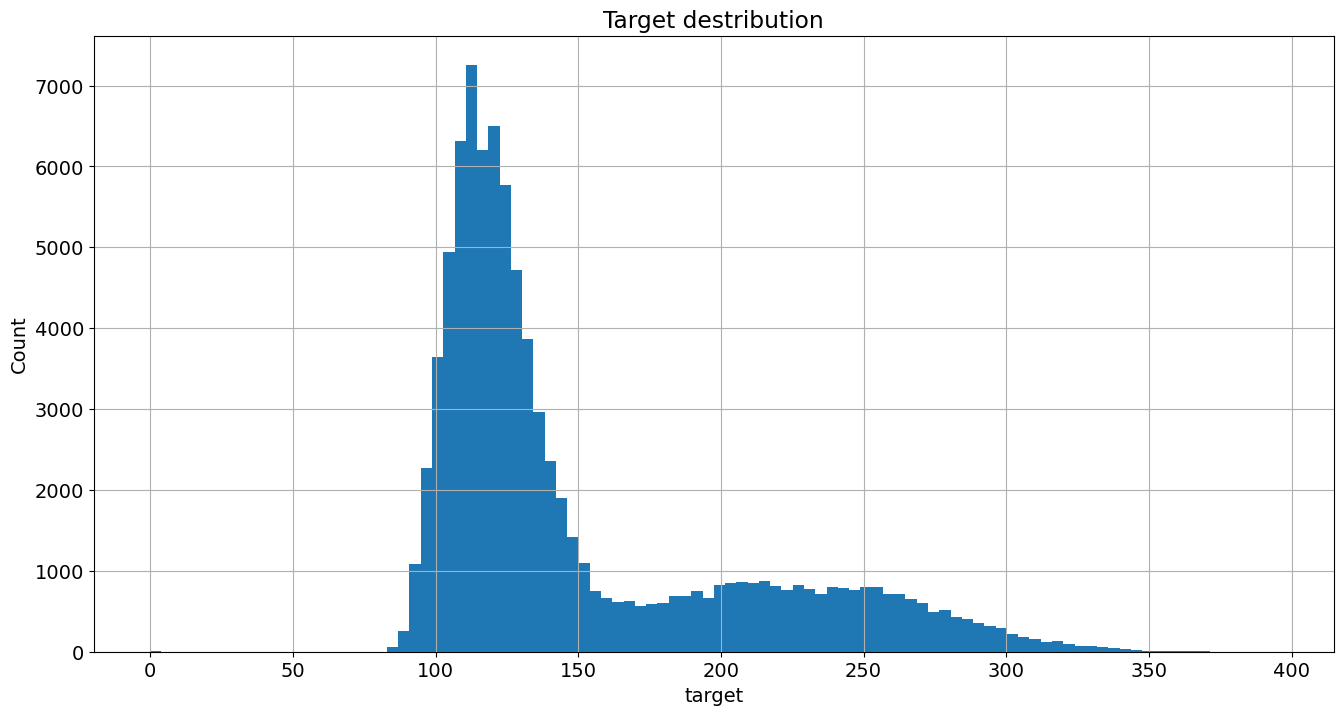

In [11]:
# Построим гистограмму целевой переменной в тренировочном датасете

plt.figure(figsize = (16, 8))

train_df['load'].hist(bins = 100)
plt.ylabel('Count')
plt.xlabel('target')

plt.title('Target destribution')
plt.show()

#### Колличественные переменные

In [12]:
# Посмотрим статистические показатели количественных переменных из тренировочной выборки

train_df.describe()

,P,Gb(i),Gd(i),H_sun,T2m,WS10m,load,residual_load,dataset_id
count,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.000000,88712.00000
mean,98.887196,83.852409,67.647893,13.390366,10.572120,2.654056,150.889231,52.002035,6.00000
std,156.181994,174.693658,94.852379,17.677984,7.895799,1.365934,55.654666,143.947973,3.16221
min,0.000000,0.000000,0.000000,0.000000,-11.250000,0.000000,0.000000,-533.480000,1.00000
25%,0.000000,0.000000,0.000000,0.000000,4.090000,1.660000,113.000000,21.150000,3.00000
50%,2.070000,0.000000,6.975000,2.080000,10.420000,2.380000,126.500000,111.000000,6.00000
75%,146.150000,58.102500,118.062500,24.030000,16.480000,3.450000,178.500000,128.500000,9.00000
max,664.030000,964.890000,442.720000,62.020000,34.050000,11.590000,395.000000,359.670000,11.00000


array([[<AxesSubplot:title={'center':'P'}>,
        <AxesSubplot:title={'center':'Gb(i)'}>,
        <AxesSubplot:title={'center':'Gd(i)'}>],
       [<AxesSubplot:title={'center':'H_sun'}>,
        <AxesSubplot:title={'center':'T2m'}>,
        <AxesSubplot:title={'center':'WS10m'}>],
       [<AxesSubplot:title={'center':'load'}>,
        <AxesSubplot:title={'center':'residual_load'}>,
        <AxesSubplot:title={'center':'dataset_id'}>]], dtype=object)

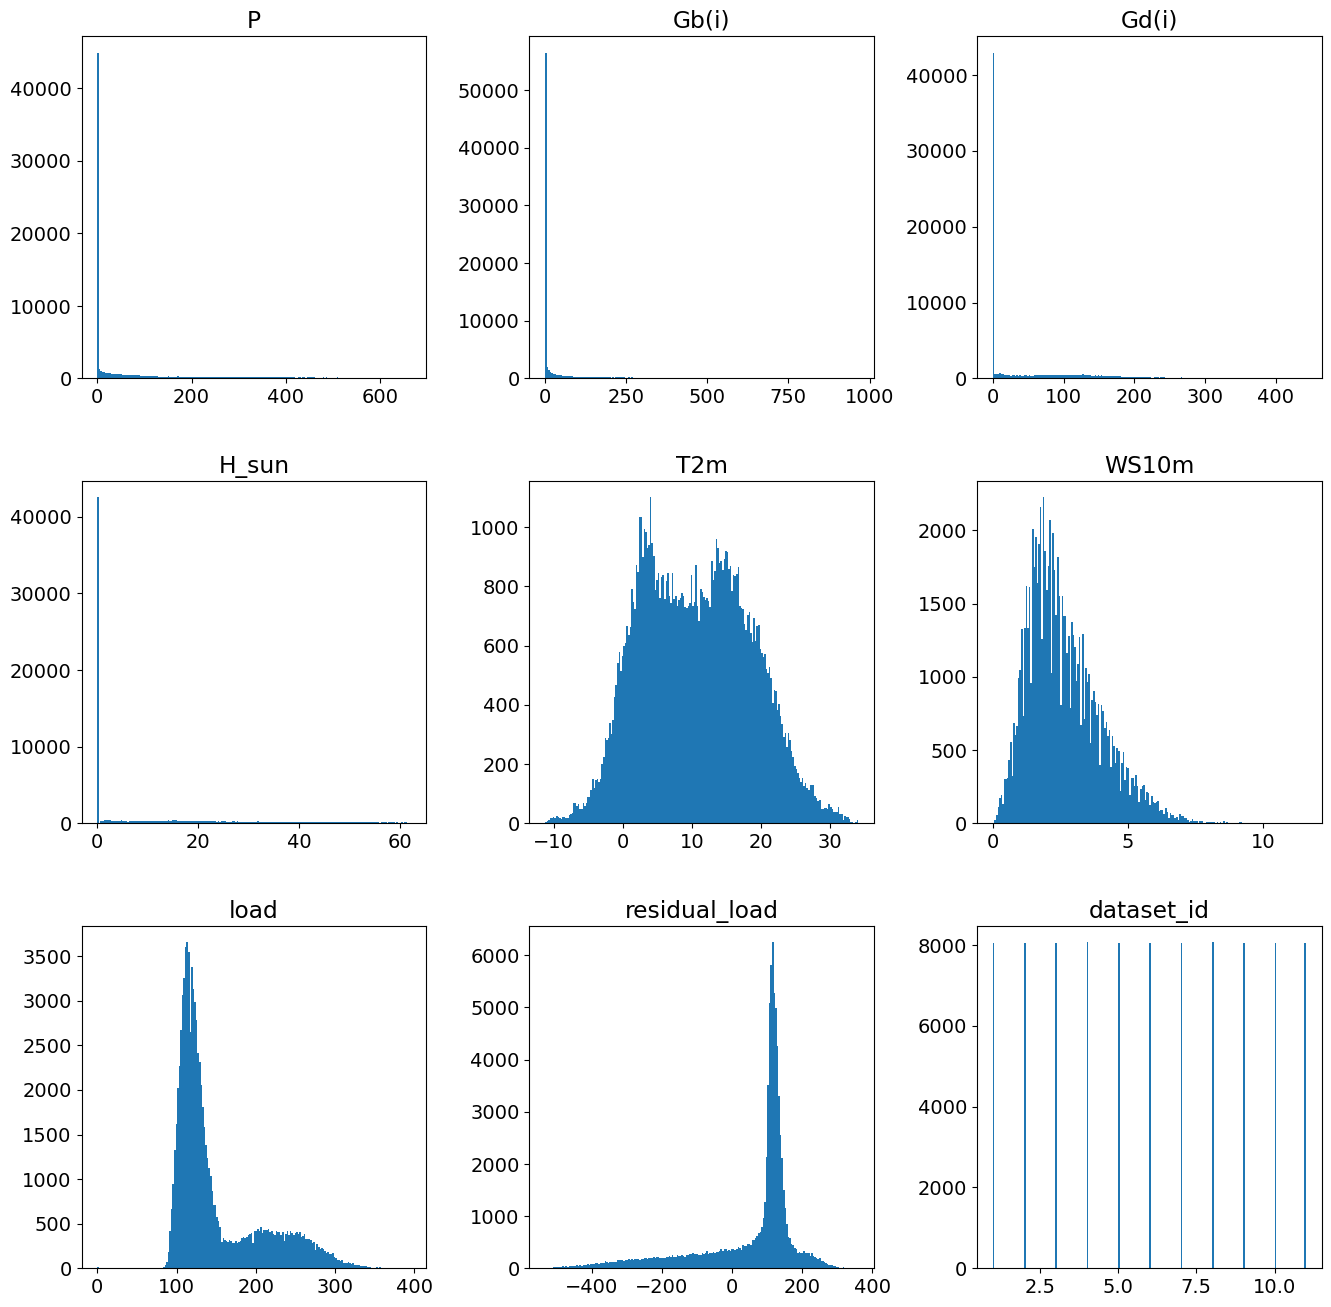

In [13]:
# Выведем гистограмму признаков

train_df.hist(figsize = (16, 16), bins = 200, grid = False)

---

#### Номинативные переменные

In [14]:
# Выведем наименования колонок с номинативными переменными

train_df.select_dtypes(include = 'object').columns.tolist()

['time']

In [15]:
# Посмотрим колличественное распределение уникальных значений переменной 'atm_id'

train_df['time'].value_counts().head(20)

2019-10-27 03:00:00    2
2018-10-28 03:00:00    2
2018-10-28 02:45:00    2
2018-10-28 02:30:00    2
2019-10-27 02:15:00    2
2019-10-27 02:30:00    2
2019-10-27 02:45:00    2
2018-10-28 02:15:00    2
2019-11-10 23:45:00    1
2019-11-11 01:00:00    1
2019-11-11 00:45:00    1
2019-11-11 00:30:00    1
2019-11-11 00:15:00    1
2019-11-11 00:00:00    1
2018-01-01 00:00:00    1
2019-11-10 23:30:00    1
2019-11-11 01:30:00    1
2019-11-10 23:15:00    1
2019-11-10 23:00:00    1
2019-11-10 22:45:00    1
Name: time, dtype: int64

---

### 1.2 test

In [16]:
# Посмотрим статистические показатели количественных переменных из тестовой выборки

test_df.describe()

,Gb(i),Gd(i),H_sun,T2m,WS10m,dataset_id
count,7392.000000,7392.000000,7392.000000,7392.000000,7392.000000,7392.000000
mean,80.685060,64.977446,13.516040,9.652251,2.602815,6.000000
std,181.548318,89.844029,17.661672,5.953256,1.205048,3.162492
min,0.000000,0.000000,0.000000,-3.810000,0.070000,1.000000
25%,0.000000,0.000000,0.000000,5.280000,1.670000,3.000000
50%,0.000000,7.940000,2.355000,8.485000,2.390000,6.000000
75%,32.582500,117.105000,25.765000,13.822500,3.520000,9.000000
max,965.600000,440.600000,61.890000,25.910000,6.760000,11.000000


array([[<AxesSubplot:title={'center':'Gb(i)'}>,
        <AxesSubplot:title={'center':'Gd(i)'}>],
       [<AxesSubplot:title={'center':'H_sun'}>,
        <AxesSubplot:title={'center':'T2m'}>],
       [<AxesSubplot:title={'center':'WS10m'}>,
        <AxesSubplot:title={'center':'dataset_id'}>]], dtype=object)

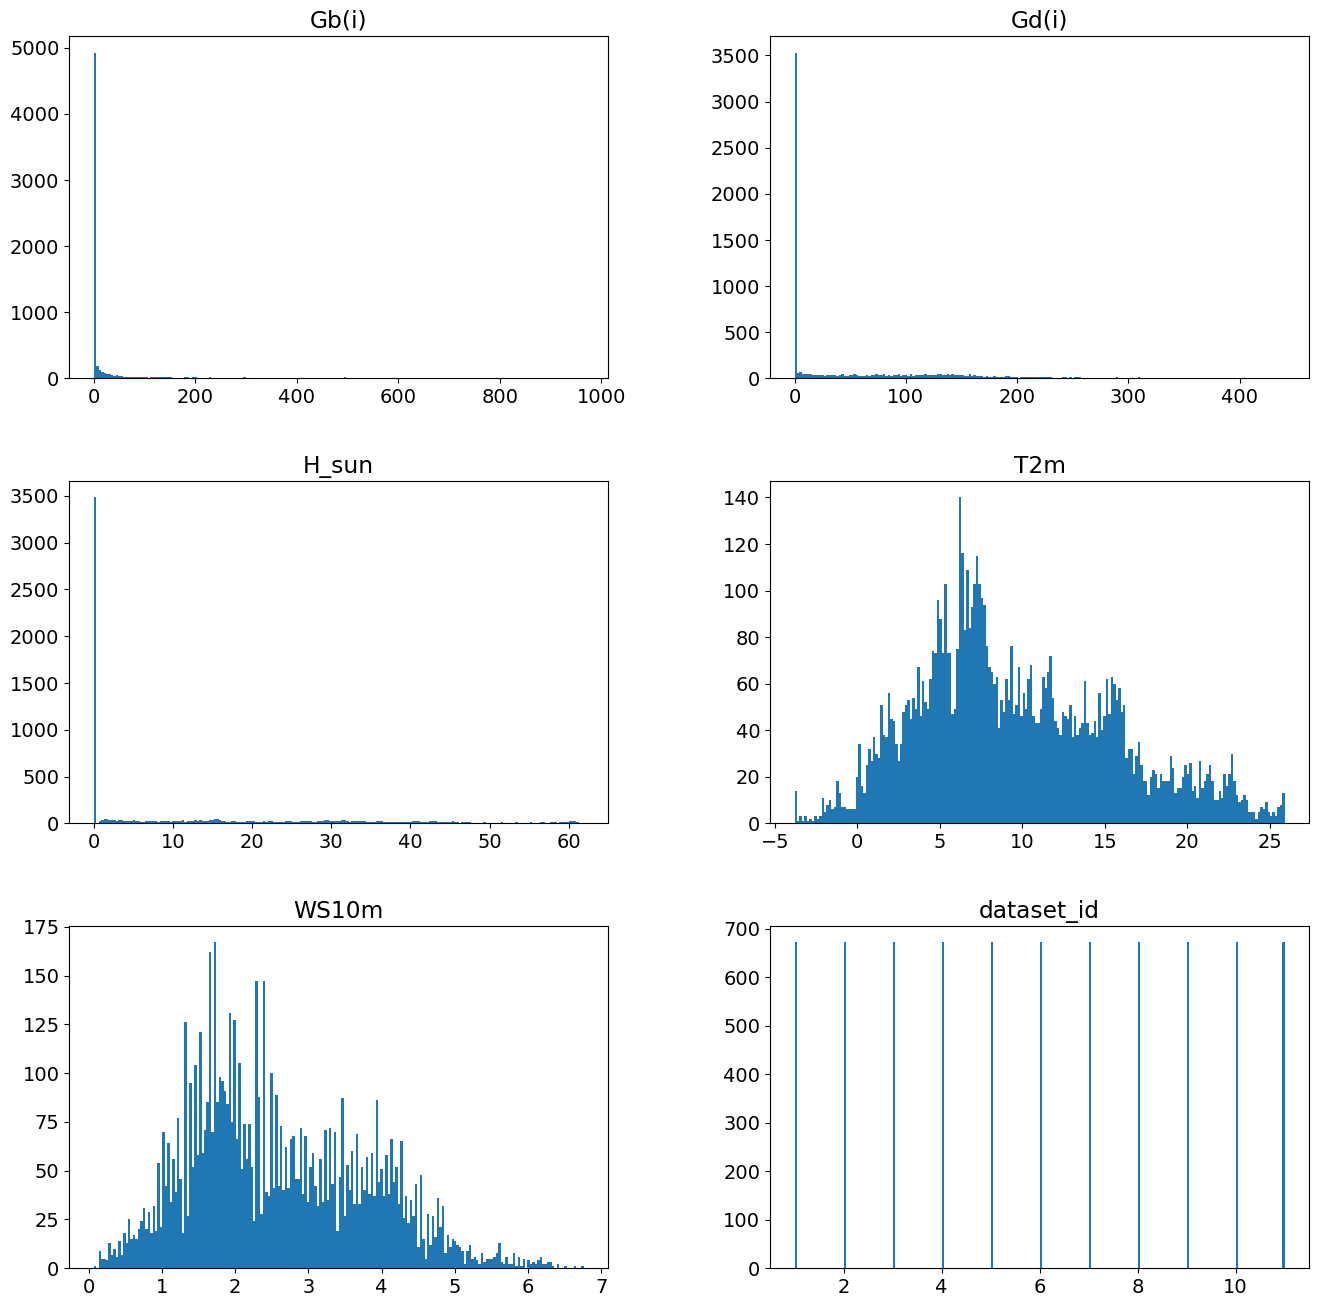

In [17]:
# Выведем гистограмму признаков

test_df.hist(figsize = (16, 16), bins = 200, grid = False)

---

#### Номинативные переменные

In [18]:
# Выведем наименования колонок с номинативными переменными

test_df.select_dtypes(include = 'object').columns.tolist()

['time']

In [19]:
# Посмотрим колличественное распределение уникальных значений переменной 'time'

test_df['time'].value_counts()

2018-03-26 00:00:00    1
2020-01-08 10:15:00    1
2020-01-08 09:45:00    1
2020-01-08 09:30:00    1
2020-01-08 09:15:00    1
                      ..
2019-01-03 15:00:00    1
2019-01-03 14:45:00    1
2019-01-03 14:30:00    1
2019-01-03 14:15:00    1
2020-10-17 23:45:00    1
Name: time, Length: 7392, dtype: int64

---

### 2. Обработка выбросов

In [20]:
# Обработка выбросов не требуется

---

### 3. Обработка пропусков

Удаление

In [21]:
# Создадим копию первоначального тренировочного датасета
train_df_original = train_df.copy()

In [22]:
# Удалим ненужные столбцы из тренировочного и тестового датасетов
train_df.drop(["dataset_id"], axis=1, inplace=True)
test_df.drop(["dataset_id"], axis=1, inplace=True)

In [23]:
# Удалим ненужные столбцы из тренировочного и тестового датасетов
train_df.drop(["P"], axis=1, inplace=True)
train_df.drop(["residual_load"], axis=1, inplace=True)

---

### 4. Построение новых признаков

In [24]:
train_df.head()

,time,Gb(i),Gd(i),H_sun,T2m,WS10m,load
0,2018-01-01 00:00:00,0.0,0.0,0.0,9.11,5.38,113.5
1,2018-01-01 00:15:00,0.0,0.0,0.0,8.89,5.43,119.0
2,2018-01-01 00:30:00,0.0,0.0,0.0,8.66,5.48,117.5
3,2018-01-01 00:45:00,0.0,0.0,0.0,8.44,5.54,114.5
4,2018-01-01 01:00:00,0.0,0.0,0.0,8.22,5.59,123.0


In [25]:
test_df.head()

,time,Gb(i),Gd(i),H_sun,T2m,WS10m
0,2018-03-26 00:00:00,0.0,0.0,0.0,1.76,1.52
1,2018-03-26 00:15:00,0.0,0.0,0.0,1.57,1.52
2,2018-03-26 00:30:00,0.0,0.0,0.0,1.38,1.52
3,2018-03-26 00:45:00,0.0,0.0,0.0,1.19,1.52
4,2018-03-26 01:00:00,0.0,0.0,0.0,1.00,1.52


In [26]:
# Создадим признаки на основе даты в тренировочно датасете

train_df["year"] = pd.DatetimeIndex(train_df["time"]).year.map(str)
train_df["month"] = pd.DatetimeIndex(train_df["time"]).month.map(str)
train_df["day"] = pd.DatetimeIndex(train_df["time"]).day.map(str)
train_df["weekday"] = pd.DatetimeIndex(train_df["time"]).weekday.map(str)

train_df["time"] = pd.to_datetime(train_df["time"])
train_df["15m_interval"] = train_df["time"].dt.hour * 4 + train_df["time"].dt.minute // 15
train_df["15m_interval"] = train_df["15m_interval"].astype(str)
train_df["time"] = train_df["time"].astype(str)

train_df.head()

,time,Gb(i),Gd(i),H_sun,T2m,WS10m,load,year,month,day,weekday,15m_interval
0,2018-01-01 00:00:00,0.0,0.0,0.0,9.11,5.38,113.5,2018,1,1,0,0
1,2018-01-01 00:15:00,0.0,0.0,0.0,8.89,5.43,119.0,2018,1,1,0,1
2,2018-01-01 00:30:00,0.0,0.0,0.0,8.66,5.48,117.5,2018,1,1,0,2
3,2018-01-01 00:45:00,0.0,0.0,0.0,8.44,5.54,114.5,2018,1,1,0,3
4,2018-01-01 01:00:00,0.0,0.0,0.0,8.22,5.59,123.0,2018,1,1,0,4


In [27]:
# Создадим признаки на основе даты в тестовом датасете

test_df["year"] = pd.DatetimeIndex(test_df["time"]).year.map(str)
test_df["month"] = pd.DatetimeIndex(test_df["time"]).month.map(str)
test_df["day"] = pd.DatetimeIndex(test_df["time"]).day.map(str)
test_df["weekday"] = pd.DatetimeIndex(test_df["time"]).weekday.map(str)

test_df["time"] = pd.to_datetime(test_df["time"])
test_df["15m_interval"] = test_df["time"].dt.hour * 4 + test_df["time"].dt.minute // 15
test_df["15m_interval"] = test_df["15m_interval"].astype(str)
test_df["time"] = test_df["time"].astype(str)

test_df.head()

,time,Gb(i),Gd(i),H_sun,T2m,WS10m,year,month,day,weekday,15m_interval
0,2018-03-26 00:00:00,0.0,0.0,0.0,1.76,1.52,2018,3,26,0,0
1,2018-03-26 00:15:00,0.0,0.0,0.0,1.57,1.52,2018,3,26,0,1
2,2018-03-26 00:30:00,0.0,0.0,0.0,1.38,1.52,2018,3,26,0,2
3,2018-03-26 00:45:00,0.0,0.0,0.0,1.19,1.52,2018,3,26,0,3
4,2018-03-26 01:00:00,0.0,0.0,0.0,1.00,1.52,2018,3,26,0,4


In [28]:
train_df.tail()

,time,Gb(i),Gd(i),H_sun,T2m,WS10m,load,year,month,day,weekday,15m_interval
88707,2020-10-10 22:45:00,0.0,0.0,0.0,6.49,2.83,99.5,2020,10,10,5,91
88708,2020-10-10 23:00:00,0.0,0.0,0.0,6.39,2.83,96.5,2020,10,10,5,92
88709,2020-10-10 23:15:00,0.0,0.0,0.0,6.34,2.83,100.5,2020,10,10,5,93
88710,2020-10-10 23:30:00,0.0,0.0,0.0,6.30,2.83,97.5,2020,10,10,5,94
88711,2020-10-10 23:45:00,0.0,0.0,0.0,6.26,2.83,102.5,2020,10,10,5,95


In [29]:
# Создадим серию с целевой переменной тренировочного датасета

train_target_df = train_df["load"].copy()
train_target_df.head()

0    113.5
1    119.0
2    117.5
3    114.5
4    123.0
Name: load, dtype: float64

In [30]:
# Создадим списки с уникальными значениями для каждого параметра даты

year_unique_list = list(train_df['year'].unique())
month_unique_list = list(train_df['month'].unique())
day_unique_list = list(train_df['day'].unique())
weekday_unique_list = list(train_df['weekday'].unique())
_15m_interval_unique_list = list(train_df['15m_interval'].unique())

In [31]:
# Создадим словари со средними значениями потребляемой мощности 'load' для каждого уникального параметра даты

year_mean_dict = dict()
for i in year_unique_list:
    year_mean_dict[i] = float(train_df[train_df['year'] == i].groupby(['year']).agg('load').mean())
year_mean_df = pd.DataFrame.from_dict(year_mean_dict, orient='index').reset_index()
year_mean_df.columns = ['year', 'mean_year_load']

month_mean_dict = dict()
for i in month_unique_list:
    month_mean_dict[i] = float(train_df[train_df['month'] == i].groupby(['month']).agg('load').mean())
month_mean_df = pd.DataFrame.from_dict(month_mean_dict, orient='index').reset_index()
month_mean_df.columns = ['month', 'mean_month_load']

day_mean_dict = dict()
for i in day_unique_list:
    day_mean_dict[i] = float(train_df[train_df['day'] == i].groupby(['day']).agg('load').mean())
day_mean_df = pd.DataFrame.from_dict(day_mean_dict, orient='index').reset_index()
day_mean_df.columns = ['day', 'mean_day_load']

weekday_mean_dict = dict()
for i in weekday_unique_list:
    weekday_mean_dict[i] = float(train_df[train_df['weekday'] == i].groupby(['weekday']).agg('load').mean())
weekday_mean_df = pd.DataFrame.from_dict(weekday_mean_dict, orient='index').reset_index()
weekday_mean_df.columns = ['weekday', 'mean_weekday_load']

_15m_interval_mean_dict = dict()
for i in _15m_interval_unique_list:
    _15m_interval_mean_dict[i] = float(train_df[train_df['15m_interval'] == i].groupby(['15m_interval']).agg('load').mean())
_15m_interval_mean_df = pd.DataFrame.from_dict(_15m_interval_mean_dict, orient='index').reset_index()
_15m_interval_mean_df.columns = ['15m_interval', 'mean_15m_interval_load']


# Добавим столбцы средних значений в тренировочный датафрейм
train_df = train_df.merge(year_mean_df, on='year', how='left')
train_df = train_df.merge(month_mean_df, on='month', how='left')
train_df = train_df.merge(day_mean_df, on='day', how='left')
train_df = train_df.merge(weekday_mean_df, on='weekday', how='left')
train_df = train_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')

# Добавим столбцы средних значений в тестовый датафрейм
test_df = test_df.merge(year_mean_df, on='year', how='left')
test_df = test_df.merge(month_mean_df, on='month', how='left')
test_df = test_df.merge(day_mean_df, on='day', how='left')
test_df = test_df.merge(weekday_mean_df, on='weekday', how='left')
test_df = test_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')

# Создадим словари со средними значениями 'Gb(i)' для каждого уникального параметра даты

year_mean_dict = dict()
for i in year_unique_list:
    year_mean_dict[i] = float(train_df[train_df['year'] == i].groupby(['year']).agg('Gb(i)').mean())
year_mean_df = pd.DataFrame.from_dict(year_mean_dict, orient='index').reset_index()
year_mean_df.columns = ['year', 'mean_year_Gb(i)']

month_mean_dict = dict()
for i in month_unique_list:
    month_mean_dict[i] = float(train_df[train_df['month'] == i].groupby(['month']).agg('Gb(i)').mean())
month_mean_df = pd.DataFrame.from_dict(month_mean_dict, orient='index').reset_index()
month_mean_df.columns = ['month', 'mean_month_Gb(i)']

day_mean_dict = dict()
for i in day_unique_list:
    day_mean_dict[i] = float(train_df[train_df['day'] == i].groupby(['day']).agg('Gb(i)').mean())
day_mean_df = pd.DataFrame.from_dict(day_mean_dict, orient='index').reset_index()
day_mean_df.columns = ['day', 'mean_day_Gb(i)']

weekday_mean_dict = dict()
for i in weekday_unique_list:
    weekday_mean_dict[i] = float(train_df[train_df['weekday'] == i].groupby(['weekday']).agg('Gb(i)').mean())
weekday_mean_df = pd.DataFrame.from_dict(weekday_mean_dict, orient='index').reset_index()
weekday_mean_df.columns = ['weekday', 'mean_weekday_Gb(i)']

_15m_interval_mean_dict = dict()
for i in _15m_interval_unique_list:
    _15m_interval_mean_dict[i] = float(train_df[train_df['15m_interval'] == i].groupby(['15m_interval']).agg('Gb(i)').mean())
_15m_interval_mean_df = pd.DataFrame.from_dict(_15m_interval_mean_dict, orient='index').reset_index()
_15m_interval_mean_df.columns = ['15m_interval', 'mean_15m_interval_Gb(i)']


# Добавим столбцы средних значений в тренировочный датафрейм
train_df = train_df.merge(year_mean_df, on='year', how='left')
train_df = train_df.merge(month_mean_df, on='month', how='left')
train_df = train_df.merge(day_mean_df, on='day', how='left')
train_df = train_df.merge(weekday_mean_df, on='weekday', how='left')
train_df = train_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')

# Добавим столбцы средних значений в тестовый датафрейм
test_df = test_df.merge(year_mean_df, on='year', how='left')
test_df = test_df.merge(month_mean_df, on='month', how='left')
test_df = test_df.merge(day_mean_df, on='day', how='left')
test_df = test_df.merge(weekday_mean_df, on='weekday', how='left')
test_df = test_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')


# Создадим словари со средними значениями 'Gd(i)' для каждого уникального параметра даты

year_mean_dict = dict()
for i in year_unique_list:
    year_mean_dict[i] = float(train_df[train_df['year'] == i].groupby(['year']).agg('Gd(i)').mean())
year_mean_df = pd.DataFrame.from_dict(year_mean_dict, orient='index').reset_index()
year_mean_df.columns = ['year', 'mean_year_Gd(i)']

month_mean_dict = dict()
for i in month_unique_list:
    month_mean_dict[i] = float(train_df[train_df['month'] == i].groupby(['month']).agg('Gd(i)').mean())
month_mean_df = pd.DataFrame.from_dict(month_mean_dict, orient='index').reset_index()
month_mean_df.columns = ['month', 'mean_month_Gd(i)']

day_mean_dict = dict()
for i in day_unique_list:
    day_mean_dict[i] = float(train_df[train_df['day'] == i].groupby(['day']).agg('Gd(i)').mean())
day_mean_df = pd.DataFrame.from_dict(day_mean_dict, orient='index').reset_index()
day_mean_df.columns = ['day', 'mean_day_Gd(i)']

weekday_mean_dict = dict()
for i in weekday_unique_list:
    weekday_mean_dict[i] = float(train_df[train_df['weekday'] == i].groupby(['weekday']).agg('Gd(i)').mean())
weekday_mean_df = pd.DataFrame.from_dict(weekday_mean_dict, orient='index').reset_index()
weekday_mean_df.columns = ['weekday', 'mean_weekday_Gd(i)']

_15m_interval_mean_dict = dict()
for i in _15m_interval_unique_list:
    _15m_interval_mean_dict[i] = float(train_df[train_df['15m_interval'] == i].groupby(['15m_interval']).agg('Gd(i)').mean())
_15m_interval_mean_df = pd.DataFrame.from_dict(_15m_interval_mean_dict, orient='index').reset_index()
_15m_interval_mean_df.columns = ['15m_interval', 'mean_15m_interval_Gd(i)']


# Добавим столбцы средних значений в тренировочный датафрейм
train_df = train_df.merge(year_mean_df, on='year', how='left')
train_df = train_df.merge(month_mean_df, on='month', how='left')
train_df = train_df.merge(day_mean_df, on='day', how='left')
train_df = train_df.merge(weekday_mean_df, on='weekday', how='left')
train_df = train_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')

# Добавим столбцы средних значений в тестовый датафрейм
test_df = test_df.merge(year_mean_df, on='year', how='left')
test_df = test_df.merge(month_mean_df, on='month', how='left')
test_df = test_df.merge(day_mean_df, on='day', how='left')
test_df = test_df.merge(weekday_mean_df, on='weekday', how='left')
test_df = test_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')

# Создадим словари со средними значениями 'H_sun' для каждого уникального параметра даты

year_mean_dict = dict()
for i in year_unique_list:
    year_mean_dict[i] = float(train_df[train_df['year'] == i].groupby(['year']).agg('H_sun').mean())
year_mean_df = pd.DataFrame.from_dict(year_mean_dict, orient='index').reset_index()
year_mean_df.columns = ['year', 'mean_year_H_sun']

month_mean_dict = dict()
for i in month_unique_list:
    month_mean_dict[i] = float(train_df[train_df['month'] == i].groupby(['month']).agg('H_sun').mean())
month_mean_df = pd.DataFrame.from_dict(month_mean_dict, orient='index').reset_index()
month_mean_df.columns = ['month', 'mean_month_H_sun']

day_mean_dict = dict()
for i in day_unique_list:
    day_mean_dict[i] = float(train_df[train_df['day'] == i].groupby(['day']).agg('H_sun').mean())
day_mean_df = pd.DataFrame.from_dict(day_mean_dict, orient='index').reset_index()
day_mean_df.columns = ['day', 'mean_day_H_sun']

weekday_mean_dict = dict()
for i in weekday_unique_list:
    weekday_mean_dict[i] = float(train_df[train_df['weekday'] == i].groupby(['weekday']).agg('H_sun').mean())
weekday_mean_df = pd.DataFrame.from_dict(weekday_mean_dict, orient='index').reset_index()
weekday_mean_df.columns = ['weekday', 'mean_weekday_H_sun']

_15m_interval_mean_dict = dict()
for i in _15m_interval_unique_list:
    _15m_interval_mean_dict[i] = float(train_df[train_df['15m_interval'] == i].groupby(['15m_interval']).agg('H_sun').mean())
_15m_interval_mean_df = pd.DataFrame.from_dict(_15m_interval_mean_dict, orient='index').reset_index()
_15m_interval_mean_df.columns = ['15m_interval', 'mean_15m_interval_H_sun']


# Добавим столбцы средних значений в тренировочный датафрейм
train_df = train_df.merge(year_mean_df, on='year', how='left')
train_df = train_df.merge(month_mean_df, on='month', how='left')
train_df = train_df.merge(day_mean_df, on='day', how='left')
train_df = train_df.merge(weekday_mean_df, on='weekday', how='left')
train_df = train_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')

# Добавим столбцы средних значений в тестовый датафрейм
test_df = test_df.merge(year_mean_df, on='year', how='left')
test_df = test_df.merge(month_mean_df, on='month', how='left')
test_df = test_df.merge(day_mean_df, on='day', how='left')
test_df = test_df.merge(weekday_mean_df, on='weekday', how='left')
test_df = test_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')


# Создадим словари со средними значениями 'T2m' для каждого уникального параметра даты

year_mean_dict = dict()
for i in year_unique_list:
    year_mean_dict[i] = float(train_df[train_df['year'] == i].groupby(['year']).agg('T2m').mean())
year_mean_df = pd.DataFrame.from_dict(year_mean_dict, orient='index').reset_index()
year_mean_df.columns = ['year', 'mean_year_T2m']

month_mean_dict = dict()
for i in month_unique_list:
    month_mean_dict[i] = float(train_df[train_df['month'] == i].groupby(['month']).agg('T2m').mean())
month_mean_df = pd.DataFrame.from_dict(month_mean_dict, orient='index').reset_index()
month_mean_df.columns = ['month', 'mean_month_T2m']

day_mean_dict = dict()
for i in day_unique_list:
    day_mean_dict[i] = float(train_df[train_df['day'] == i].groupby(['day']).agg('T2m').mean())
day_mean_df = pd.DataFrame.from_dict(day_mean_dict, orient='index').reset_index()
day_mean_df.columns = ['day', 'mean_day_T2m']

weekday_mean_dict = dict()
for i in weekday_unique_list:
    weekday_mean_dict[i] = float(train_df[train_df['weekday'] == i].groupby(['weekday']).agg('T2m').mean())
weekday_mean_df = pd.DataFrame.from_dict(weekday_mean_dict, orient='index').reset_index()
weekday_mean_df.columns = ['weekday', 'mean_weekday_T2m']

_15m_interval_mean_dict = dict()
for i in _15m_interval_unique_list:
    _15m_interval_mean_dict[i] = float(train_df[train_df['15m_interval'] == i].groupby(['15m_interval']).agg('T2m').mean())
_15m_interval_mean_df = pd.DataFrame.from_dict(_15m_interval_mean_dict, orient='index').reset_index()
_15m_interval_mean_df.columns = ['15m_interval', 'mean_15m_interval_T2m']


# Добавим столбцы средних значений в тренировочный датафрейм
train_df = train_df.merge(year_mean_df, on='year', how='left')
train_df = train_df.merge(month_mean_df, on='month', how='left')
train_df = train_df.merge(day_mean_df, on='day', how='left')
train_df = train_df.merge(weekday_mean_df, on='weekday', how='left')
train_df = train_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')

# Добавим столбцы средних значений в тестовый датафрейм
test_df = test_df.merge(year_mean_df, on='year', how='left')
test_df = test_df.merge(month_mean_df, on='month', how='left')
test_df = test_df.merge(day_mean_df, on='day', how='left')
test_df = test_df.merge(weekday_mean_df, on='weekday', how='left')
test_df = test_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')


# Создадим словари со средними значениями 'WS10m' для каждого уникального параметра даты

year_mean_dict = dict()
for i in year_unique_list:
    year_mean_dict[i] = float(train_df[train_df['year'] == i].groupby(['year']).agg('WS10m').mean())
year_mean_df = pd.DataFrame.from_dict(year_mean_dict, orient='index').reset_index()
year_mean_df.columns = ['year', 'mean_year_WS10m']

month_mean_dict = dict()
for i in month_unique_list:
    month_mean_dict[i] = float(train_df[train_df['month'] == i].groupby(['month']).agg('WS10m').mean())
month_mean_df = pd.DataFrame.from_dict(month_mean_dict, orient='index').reset_index()
month_mean_df.columns = ['month', 'mean_month_WS10m']

day_mean_dict = dict()
for i in day_unique_list:
    day_mean_dict[i] = float(train_df[train_df['day'] == i].groupby(['day']).agg('WS10m').mean())
day_mean_df = pd.DataFrame.from_dict(day_mean_dict, orient='index').reset_index()
day_mean_df.columns = ['day', 'mean_day_WS10m']

weekday_mean_dict = dict()
for i in weekday_unique_list:
    weekday_mean_dict[i] = float(train_df[train_df['weekday'] == i].groupby(['weekday']).agg('WS10m').mean())
weekday_mean_df = pd.DataFrame.from_dict(weekday_mean_dict, orient='index').reset_index()
weekday_mean_df.columns = ['weekday', 'mean_weekday_WS10m']

_15m_interval_mean_dict = dict()
for i in _15m_interval_unique_list:
    _15m_interval_mean_dict[i] = float(train_df[train_df['15m_interval'] == i].groupby(['15m_interval']).agg('WS10m').mean())
_15m_interval_mean_df = pd.DataFrame.from_dict(_15m_interval_mean_dict, orient='index').reset_index()
_15m_interval_mean_df.columns = ['15m_interval', 'mean_15m_interval_WS10m']


# Добавим столбцы средних значений в тренировочный датафрейм
train_df = train_df.merge(year_mean_df, on='year', how='left')
train_df = train_df.merge(month_mean_df, on='month', how='left')
train_df = train_df.merge(day_mean_df, on='day', how='left')
train_df = train_df.merge(weekday_mean_df, on='weekday', how='left')
train_df = train_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')

# Добавим столбцы средних значений в тестовый датафрейм
test_df = test_df.merge(year_mean_df, on='year', how='left')
test_df = test_df.merge(month_mean_df, on='month', how='left')
test_df = test_df.merge(day_mean_df, on='day', how='left')
test_df = test_df.merge(weekday_mean_df, on='weekday', how='left')
test_df = test_df.merge(_15m_interval_mean_df, on='15m_interval', how='left')



In [32]:
str_columns_1 = train_df.columns
print(str_columns_1)

Index(['time', 'Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m', 'load', 'year',
       'month', 'day', 'weekday', '15m_interval', 'mean_year_load',
       'mean_month_load', 'mean_day_load', 'mean_weekday_load',
       'mean_15m_interval_load', 'mean_year_Gb(i)', 'mean_month_Gb(i)',
       'mean_day_Gb(i)', 'mean_weekday_Gb(i)', 'mean_15m_interval_Gb(i)',
       'mean_year_Gd(i)', 'mean_month_Gd(i)', 'mean_day_Gd(i)',
       'mean_weekday_Gd(i)', 'mean_15m_interval_Gd(i)', 'mean_year_H_sun',
       'mean_month_H_sun', 'mean_day_H_sun', 'mean_weekday_H_sun',
       'mean_15m_interval_H_sun', 'mean_year_T2m', 'mean_month_T2m',
       'mean_day_T2m', 'mean_weekday_T2m', 'mean_15m_interval_T2m',
       'mean_year_WS10m', 'mean_month_WS10m', 'mean_day_WS10m',
       'mean_weekday_WS10m', 'mean_15m_interval_WS10m'],
      dtype='object')


In [33]:
list_columns_1 = list(train_df.columns)
print(list_columns_1)

['time', 'Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m', 'load', 'year', 'month', 'day', 'weekday', '15m_interval', 'mean_year_load', 'mean_month_load', 'mean_day_load', 'mean_weekday_load', 'mean_15m_interval_load', 'mean_year_Gb(i)', 'mean_month_Gb(i)', 'mean_day_Gb(i)', 'mean_weekday_Gb(i)', 'mean_15m_interval_Gb(i)', 'mean_year_Gd(i)', 'mean_month_Gd(i)', 'mean_day_Gd(i)', 'mean_weekday_Gd(i)', 'mean_15m_interval_Gd(i)', 'mean_year_H_sun', 'mean_month_H_sun', 'mean_day_H_sun', 'mean_weekday_H_sun', 'mean_15m_interval_H_sun', 'mean_year_T2m', 'mean_month_T2m', 'mean_day_T2m', 'mean_weekday_T2m', 'mean_15m_interval_T2m', 'mean_year_WS10m', 'mean_month_WS10m', 'mean_day_WS10m', 'mean_weekday_WS10m', 'mean_15m_interval_WS10m']


In [34]:
# Построим новые признаки для тренировочного датасета 1

# Gd(i)
train_df['Gd(i)_divide_H_sun'] = train_df['Gd(i)'] / train_df['H_sun']

# H_sun
train_df['H_sun_minus_T2m'] = train_df['H_sun'] - train_df['T2m']

# T2m
train_df['T2m_multiply_WS10m'] = train_df['T2m'] * train_df['WS10m']

# WS10m
train_df['WS10m_divide_T2m'] = train_df['WS10m'] / train_df['T2m']

In [35]:
# train_df['Gb(i)_minus_T2m']
train_df['Gb(i)_minus_T2m_multiply_WS10m'] = (train_df['Gb(i)'] - train_df['T2m']) * train_df['WS10m']

# train_df['Gb(i)_minus_WS10m']
train_df['Gb(i)_minus_WS10m_divide_T2m'] = (train_df['Gb(i)'] - train_df['WS10m']) / train_df['T2m']

# train_df['H_sun_minus_T2m']
train_df['H_sun_minus_T2m_multiply_WS10m'] = (train_df['H_sun'] - train_df['T2m']) * train_df['WS10m']
train_df['H_sun_minus_T2m_divide_WS10m'] = (train_df['H_sun'] - train_df['T2m']) / train_df['WS10m']

# train_df['T2m_multiply_WS10m']
train_df['T2m_multiply_WS10m_minus_T2m'] = (train_df['T2m'] * train_df['WS10m']) - train_df['T2m']

# train_df['T2m_minus_WS10m']
train_df['T2m_minus_WS10m_exponentiation_2'] = (train_df['T2m'] - train_df['WS10m']) ** 2

# train_df['WS10m_divide_T2m']
train_df['WS10m_divide_T2m_plus_WS10m'] = (train_df['WS10m'] / train_df['T2m']) + train_df['WS10m']
train_df['WS10m_divide_T2m_minus_WS10m'] = (train_df['WS10m'] / train_df['T2m']) - train_df['WS10m']
train_df['WS10m_divide_T2m_divide_T2m'] = (train_df['WS10m'] / train_df['T2m']) / train_df['T2m']


In [36]:
# train_df['Gb(i)_minus_WS10m_divide_T2m']
train_df['Gb(i)_minus_WS10m_divide_T2m_minus_T2m_2'] = ((train_df['Gb(i)']*0.2 - train_df['WS10m']*7.0) / train_df['T2m']*8.0) - train_df['T2m']*3.0

# train_df['H_sun_minus_T2m_divide_WS10m']
train_df['H_sun_minus_T2m_divide_WS10m_plus_WS10m'] = ((train_df['H_sun'] - train_df['T2m']) / train_df['WS10m']) + train_df['WS10m']
train_df['H_sun_minus_T2m_divide_WS10m_minus_T2m'] = ((train_df['H_sun'] - train_df['T2m']) / train_df['WS10m']) - train_df['T2m']

# train_df['T2m_multiply_WS10m_minus_H_sun']
train_df['T2m_multiply_WS10m_minus_H_sun_exponentiation_2'] = (((train_df['T2m'] * train_df['WS10m']) - train_df['T2m']) - train_df['H_sun']) ** 2

# train_df['T2m_plus_WS10m_plus_WS10m']
train_df['T2m_plus_WS10m_plus_WS10m_plus_WS10m'] = ((train_df['T2m'] + train_df['WS10m']) + train_df['WS10m']) + train_df['WS10m']

# train_df['WS10m_divide_T2m_multiply_WS10m']
train_df['WS10m_divide_T2m_multiply_WS10m_minus_WS10m'] = ((train_df['WS10m'] / train_df['T2m']) * train_df['WS10m']) - train_df['WS10m']


In [37]:
# Генерация кода фич со случайными коэффициентами

import random

str1 = str("train_df['WS10m_divide_T2m_multiply_WS10m_minus_WS10m'] = ((train_df['WS10m'] / train_df['T2m']) * train_df['WS10m']) - train_df['WS10m']")

code_list = []
for i in range(20):
    list1 = str1.split("'")
    list1[1] = list1[1] + "_" + str(i+1)
    str2 = "'".join(list1)
    list1 = str2.split("]")
    list2 = []
    list2.append(list1[0] + "]")
    list2.append(list1[1] + f"]*{random.randint(1, 10)/10 * 10**(random.randint(0, 1))}")
    list2.append(list1[2] + f"]*{random.randint(1, 10)/10 * 10**(random.randint(0, 1))}")
    list2.append(list1[3] + f"]*{random.randint(1, 10)/10 * 10**(random.randint(0, 1))}")
    list2.append(list1[4] + f"]*{random.randint(1, 10)/10 * 10**(random.randint(0, 1))}")


    str2 = "".join(list2)    
    code_list.append(str2)

for i in code_list:
    print(i)

train_df['WS10m_divide_T2m_multiply_WS10m_minus_WS10m_1'] = ((train_df['WS10m']*6.0 / train_df['T2m']*5.0) * train_df['WS10m']*5.0) - train_df['WS10m']*5.0
train_df['WS10m_divide_T2m_multiply_WS10m_minus_WS10m_2'] = ((train_df['WS10m']*8.0 / train_df['T2m']*0.6) * train_df['WS10m']*0.9) - train_df['WS10m']*10.0
train_df['WS10m_divide_T2m_multiply_WS10m_minus_WS10m_3'] = ((train_df['WS10m']*1.0 / train_df['T2m']*7.0) * train_df['WS10m']*9.0) - train_df['WS10m']*7.0
train_df['WS10m_divide_T2m_multiply_WS10m_minus_WS10m_4'] = ((train_df['WS10m']*0.1 / train_df['T2m']*8.0) * train_df['WS10m']*0.8) - train_df['WS10m']*4.0
train_df['WS10m_divide_T2m_multiply_WS10m_minus_WS10m_5'] = ((train_df['WS10m']*0.6 / train_df['T2m']*0.2) * train_df['WS10m']*0.5) - train_df['WS10m']*9.0
train_df['WS10m_divide_T2m_multiply_WS10m_minus_WS10m_6'] = ((train_df['WS10m']*0.5 / train_df['T2m']*0.7) * train_df['WS10m']*0.9) - train_df['WS10m']*7.0
train_df['WS10m_divide_T2m_multiply_WS10m_minus_WS10m_7'] = ((t

In [38]:
# Построим новые признаки для тестового датасета 1

# Gd(i)
test_df['Gd(i)_divide_H_sun'] = test_df['Gd(i)'] / test_df['H_sun']

# H_sun
test_df['H_sun_minus_T2m'] = test_df['H_sun'] - test_df['T2m']

# T2m
test_df['T2m_multiply_WS10m'] = test_df['T2m'] * test_df['WS10m']

# WS10m
test_df['WS10m_divide_T2m'] = test_df['WS10m'] / test_df['T2m']


In [39]:
# test_df['Gb(i)_minus_T2m']
test_df['Gb(i)_minus_T2m_multiply_WS10m'] = (test_df['Gb(i)'] - test_df['T2m']) * test_df['WS10m']

# test_df['Gb(i)_minus_WS10m']
test_df['Gb(i)_minus_WS10m_divide_T2m'] = (test_df['Gb(i)'] - test_df['WS10m']) / test_df['T2m']

# test_df['H_sun_minus_T2m']
test_df['H_sun_minus_T2m_multiply_WS10m'] = test_df['H_sun_minus_T2m'] * test_df['WS10m']
test_df['H_sun_minus_T2m_divide_WS10m'] = test_df['H_sun_minus_T2m'] / test_df['WS10m']

# test_df['T2m_multiply_WS10m']
test_df['T2m_multiply_WS10m_minus_T2m'] = test_df['T2m_multiply_WS10m'] - test_df['T2m']

# test_df['T2m_minus_WS10m']
test_df['T2m_minus_WS10m_exponentiation_2'] = (test_df['T2m'] - test_df['WS10m']) ** 2

# test_df['WS10m_divide_T2m']
test_df['WS10m_divide_T2m_plus_WS10m'] = test_df['WS10m_divide_T2m'] + test_df['WS10m']
test_df['WS10m_divide_T2m_minus_WS10m'] = test_df['WS10m_divide_T2m'] - test_df['WS10m']
test_df['WS10m_divide_T2m_divide_T2m'] = test_df['WS10m_divide_T2m'] / test_df['T2m']


In [40]:
# test_df['Gb(i)_minus_WS10m_divide_T2m']
test_df['Gb(i)_minus_WS10m_divide_T2m_minus_T2m'] = test_df['Gb(i)_minus_WS10m_divide_T2m'] - test_df['T2m']

# test_df['H_sun_minus_T2m_divide_WS10m']
test_df['H_sun_minus_T2m_divide_WS10m_plus_WS10m'] = test_df['H_sun_minus_T2m_divide_WS10m'] + test_df['WS10m']
test_df['H_sun_minus_T2m_divide_WS10m_minus_T2m'] = test_df['H_sun_minus_T2m_divide_WS10m'] - test_df['T2m']

# test_df['T2m_multiply_WS10m_minus_H_sun']
test_df['T2m_multiply_WS10m_minus_H_sun_exponentiation_2'] = (test_df['T2m_multiply_WS10m'] - test_df['H_sun']) ** 2

# test_df['T2m_plus_WS10m_plus_WS10m']
test_df['T2m_plus_WS10m_plus_WS10m_plus_WS10m'] = ((test_df['T2m'] + test_df['WS10m']) + test_df['WS10m']) + test_df['WS10m']

# test_df['WS10m_divide_T2m_multiply_WS10m']
test_df['WS10m_divide_T2m_multiply_WS10m_minus_WS10m'] = (test_df['WS10m_divide_T2m'] * test_df['WS10m']) - test_df['WS10m']


In [41]:
# train_df.info()

In [42]:
# test_df.info()

In [43]:
# Создадим тренировочный датафрейм без целевой переменной

train_df1 = train_df.copy()
train_df1.drop(["load"], axis=1, inplace=True)
train_df1.head()

,time,Gb(i),Gd(i),H_sun,T2m,WS10m,year,month,day,weekday,...,T2m_minus_WS10m_exponentiation_2,WS10m_divide_T2m_plus_WS10m,WS10m_divide_T2m_minus_WS10m,WS10m_divide_T2m_divide_T2m,Gb(i)_minus_WS10m_divide_T2m_minus_T2m_2,H_sun_minus_T2m_divide_WS10m_plus_WS10m,H_sun_minus_T2m_divide_WS10m_minus_T2m,T2m_multiply_WS10m_minus_H_sun_exponentiation_2,T2m_plus_WS10m_plus_WS10m_plus_WS10m,WS10m_divide_T2m_multiply_WS10m_minus_WS10m
0,2018-01-01 00:00:00,0.0,0.0,0.0,9.11,5.38,2018,1,1,0,...,13.9129,5.970560,-4.789440,0.064825,-60.401350,3.686691,-10.803309,1592.153643,25.25,-2.202788
1,2018-01-01 00:15:00,0.0,0.0,0.0,8.89,5.43,2018,1,1,0,...,11.9716,6.040799,-4.819201,0.068706,-60.874724,3.792799,-10.527201,1550.997059,25.18,-2.113363
2,2018-01-01 00:30:00,0.0,0.0,0.0,8.66,5.48,2018,1,1,0,...,10.1124,6.112794,-4.847206,0.073071,-61.416490,3.899708,-10.240292,1505.191690,25.10,-2.012286
3,2018-01-01 00:45:00,0.0,0.0,0.0,8.44,5.54,2018,1,1,0,...,8.4100,6.196398,-4.883602,0.077772,-62.078294,4.016534,-9.963466,1468.238470,25.06,-1.903555
4,2018-01-01 01:00:00,0.0,0.0,0.0,8.22,5.59,2018,1,1,0,...,6.9169,6.270049,-4.909951,0.082731,-62.742725,4.119517,-9.690483,1423.537808,24.99,-1.788528


In [44]:
# Посмотрим размеры датафреймов перед объединением

print(f'train_df1 \t{train_df1.shape}')
print(f'test_df \t{test_df.shape}')

train_df1 	(88712, 60)
test_df 	(7392, 60)


In [45]:
# Создадим объединённый датафрейм

train_test1 = pd.concat([train_df1, test_df])
train_test1.head()

,time,Gb(i),Gd(i),H_sun,T2m,WS10m,year,month,day,weekday,...,WS10m_divide_T2m_plus_WS10m,WS10m_divide_T2m_minus_WS10m,WS10m_divide_T2m_divide_T2m,Gb(i)_minus_WS10m_divide_T2m_minus_T2m_2,H_sun_minus_T2m_divide_WS10m_plus_WS10m,H_sun_minus_T2m_divide_WS10m_minus_T2m,T2m_multiply_WS10m_minus_H_sun_exponentiation_2,T2m_plus_WS10m_plus_WS10m_plus_WS10m,WS10m_divide_T2m_multiply_WS10m_minus_WS10m,Gb(i)_minus_WS10m_divide_T2m_minus_T2m
0,2018-01-01 00:00:00,0.0,0.0,0.0,9.11,5.38,2018,1,1,0,...,5.970560,-4.789440,0.064825,-60.401350,3.686691,-10.803309,1592.153643,25.25,-2.202788,NaN
1,2018-01-01 00:15:00,0.0,0.0,0.0,8.89,5.43,2018,1,1,0,...,6.040799,-4.819201,0.068706,-60.874724,3.792799,-10.527201,1550.997059,25.18,-2.113363,NaN
2,2018-01-01 00:30:00,0.0,0.0,0.0,8.66,5.48,2018,1,1,0,...,6.112794,-4.847206,0.073071,-61.416490,3.899708,-10.240292,1505.191690,25.10,-2.012286,NaN
3,2018-01-01 00:45:00,0.0,0.0,0.0,8.44,5.54,2018,1,1,0,...,6.196398,-4.883602,0.077772,-62.078294,4.016534,-9.963466,1468.238470,25.06,-1.903555,NaN
4,2018-01-01 01:00:00,0.0,0.0,0.0,8.22,5.59,2018,1,1,0,...,6.270049,-4.909951,0.082731,-62.742725,4.119517,-9.690483,1423.537808,24.99,-1.788528,NaN


In [46]:
# Удалим столбец 'time' из объединённого датафрейма

train_test1.drop(['time'], axis=1, inplace=True)
train_test1.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,year,month,day,weekday,15m_interval,...,WS10m_divide_T2m_plus_WS10m,WS10m_divide_T2m_minus_WS10m,WS10m_divide_T2m_divide_T2m,Gb(i)_minus_WS10m_divide_T2m_minus_T2m_2,H_sun_minus_T2m_divide_WS10m_plus_WS10m,H_sun_minus_T2m_divide_WS10m_minus_T2m,T2m_multiply_WS10m_minus_H_sun_exponentiation_2,T2m_plus_WS10m_plus_WS10m_plus_WS10m,WS10m_divide_T2m_multiply_WS10m_minus_WS10m,Gb(i)_minus_WS10m_divide_T2m_minus_T2m
0,0.0,0.0,0.0,9.11,5.38,2018,1,1,0,0,...,5.970560,-4.789440,0.064825,-60.401350,3.686691,-10.803309,1592.153643,25.25,-2.202788,NaN
1,0.0,0.0,0.0,8.89,5.43,2018,1,1,0,1,...,6.040799,-4.819201,0.068706,-60.874724,3.792799,-10.527201,1550.997059,25.18,-2.113363,NaN
2,0.0,0.0,0.0,8.66,5.48,2018,1,1,0,2,...,6.112794,-4.847206,0.073071,-61.416490,3.899708,-10.240292,1505.191690,25.10,-2.012286,NaN
3,0.0,0.0,0.0,8.44,5.54,2018,1,1,0,3,...,6.196398,-4.883602,0.077772,-62.078294,4.016534,-9.963466,1468.238470,25.06,-1.903555,NaN
4,0.0,0.0,0.0,8.22,5.59,2018,1,1,0,4,...,6.270049,-4.909951,0.082731,-62.742725,4.119517,-9.690483,1423.537808,24.99,-1.788528,NaN


In [47]:
# Проверим количество строк в объединённом датафрейме

print(f'train_df1 + test_df = \t{train_df1.shape[0] + test_df.shape[0]}')
print(f'train_test1 \t\t{train_test1.shape[0]}')

train_df1 + test_df = 	96104
train_test1 		96104


In [48]:
# train_test1.info()

In [49]:
# Заменим категориальные признаки дамми-переменными в объединённом датасете
train_test2 = train_test1.copy()
train_test2 = pd.get_dummies(train_test2)
train_test2.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,mean_year_load,mean_month_load,mean_day_load,mean_weekday_load,mean_15m_interval_load,...,15m_interval_87,15m_interval_88,15m_interval_89,15m_interval_9,15m_interval_90,15m_interval_91,15m_interval_92,15m_interval_93,15m_interval_94,15m_interval_95
0,0.0,0.0,0.0,9.11,5.38,154.214197,171.168561,141.631944,166.373501,120.046537,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,8.89,5.43,154.214197,171.168561,141.631944,166.373501,119.674784,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,8.66,5.48,154.214197,171.168561,141.631944,166.373501,119.096861,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,8.44,5.54,154.214197,171.168561,141.631944,166.373501,119.370671,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,8.22,5.59,154.214197,171.168561,141.631944,166.373501,119.314394,...,0,0,0,0,0,0,0,0,0,0


In [50]:
train_df.shape[0]

88712

In [51]:
train_test2.shape[0]

96104

#### Разделим объединённый датасет обратно на train и test

In [52]:
# Получим новую тренировочную выборку
train_df3 = train_test2.iloc[0:train_df.shape[0]].copy()
# обновим индексы строк
train_df3 = train_df3.reset_index(drop=True)
train_df3.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,mean_year_load,mean_month_load,mean_day_load,mean_weekday_load,mean_15m_interval_load,...,15m_interval_87,15m_interval_88,15m_interval_89,15m_interval_9,15m_interval_90,15m_interval_91,15m_interval_92,15m_interval_93,15m_interval_94,15m_interval_95
0,0.0,0.0,0.0,9.11,5.38,154.214197,171.168561,141.631944,166.373501,120.046537,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,8.89,5.43,154.214197,171.168561,141.631944,166.373501,119.674784,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,8.66,5.48,154.214197,171.168561,141.631944,166.373501,119.096861,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,8.44,5.54,154.214197,171.168561,141.631944,166.373501,119.370671,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,8.22,5.59,154.214197,171.168561,141.631944,166.373501,119.314394,...,0,0,0,0,0,0,0,0,0,0


In [53]:
train_df3.shape

(88712, 204)

In [54]:
# Добавим целевую переменную в тренировочный датасет

train_df3['load'] = train_target_df
train_df3.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,mean_year_load,mean_month_load,mean_day_load,mean_weekday_load,mean_15m_interval_load,...,15m_interval_88,15m_interval_89,15m_interval_9,15m_interval_90,15m_interval_91,15m_interval_92,15m_interval_93,15m_interval_94,15m_interval_95,load
0,0.0,0.0,0.0,9.11,5.38,154.214197,171.168561,141.631944,166.373501,120.046537,...,0,0,0,0,0,0,0,0,0,113.5
1,0.0,0.0,0.0,8.89,5.43,154.214197,171.168561,141.631944,166.373501,119.674784,...,0,0,0,0,0,0,0,0,0,119.0
2,0.0,0.0,0.0,8.66,5.48,154.214197,171.168561,141.631944,166.373501,119.096861,...,0,0,0,0,0,0,0,0,0,117.5
3,0.0,0.0,0.0,8.44,5.54,154.214197,171.168561,141.631944,166.373501,119.370671,...,0,0,0,0,0,0,0,0,0,114.5
4,0.0,0.0,0.0,8.22,5.59,154.214197,171.168561,141.631944,166.373501,119.314394,...,0,0,0,0,0,0,0,0,0,123.0


In [55]:
# Проверим количество строк в тренировочно датафрейме

print(f'train_df = \t{train_df.shape[0]}')
print(f'train_df3 = \t{train_df3.shape[0]}')

train_df = 	88712
train_df3 = 	88712


In [56]:
# Получим новую тестовую выборку
test_df3 = train_test2.iloc[(train_test2.shape[0] - test_df.shape[0]) : train_test2.shape[0]].copy()
# обновим индексы строк
test_df3 = test_df3.reset_index(drop=True)
test_df3.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,mean_year_load,mean_month_load,mean_day_load,mean_weekday_load,mean_15m_interval_load,...,15m_interval_87,15m_interval_88,15m_interval_89,15m_interval_9,15m_interval_90,15m_interval_91,15m_interval_92,15m_interval_93,15m_interval_94,15m_interval_95
0,0.0,0.0,0.0,1.76,1.52,154.214197,158.02239,148.816732,166.373501,120.046537,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,1.57,1.52,154.214197,158.02239,148.816732,166.373501,119.674784,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,1.38,1.52,154.214197,158.02239,148.816732,166.373501,119.096861,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,1.19,1.52,154.214197,158.02239,148.816732,166.373501,119.370671,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,1.00,1.52,154.214197,158.02239,148.816732,166.373501,119.314394,...,0,0,0,0,0,0,0,0,0,0


In [57]:
test_df3.shape

(7392, 204)

In [58]:
# Проверим количество строк в тестовом датафрейме

print(f'test_df = \t{test_df.shape[0]}')
print(f'test_df3 = \t{test_df3.shape[0]}')

test_df = 	7392
test_df3 = 	7392


---

### 6. Разбиение на train и test

In [59]:
# Разделим тренировочный датасет на входные признаки и целевой признак

target_name = 'load'

X = train_df3.drop(columns=target_name)
y = train_df3[target_name]

In [60]:
# Тренировочный датасет разобъём на тренировочные и валидационные данные

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

X_train.shape, X_test.shape, test_df3.shape

((59437, 204), (29275, 204), (7392, 204))

In [61]:
# Проверим наличие пропусков в выборках

X_train.isna().sum().sum(), X_test.isna().sum().sum(), test_df3.isna().sum().sum()

(88012, 43204, 10874)

---

### 7.1.1 Построение модели для предсказания потребляемой мощности 'load'

In [62]:
%%time

# Предварительно обучим модель LGBM_model

# Light Gradient Boosting Machine Regressor (лёгкий градиентный бустинг деревьев решений - регрессор)

LGBM_model = lgb.LGBMRegressor(
    n_estimators=280,
    max_depth= 16,
    learning_rate= 0.1,
    num_leaves= 100,
    min_child_samples= 1,
    min_child_weight= 450,
    random_state= 42)

LGBM_model.fit(X_train, y_train)

Wall time: 7.21 s


LGBMRegressor(max_depth=16, min_child_samples=1, min_child_weight=450,
              n_estimators=280, num_leaves=100, random_state=42)

Train R2:	0.96
Test R2:	0.945
Train RMSE:	11.067
Test RMSE:	13.086
Train MSE:	122.474
Test MSE:	171.254


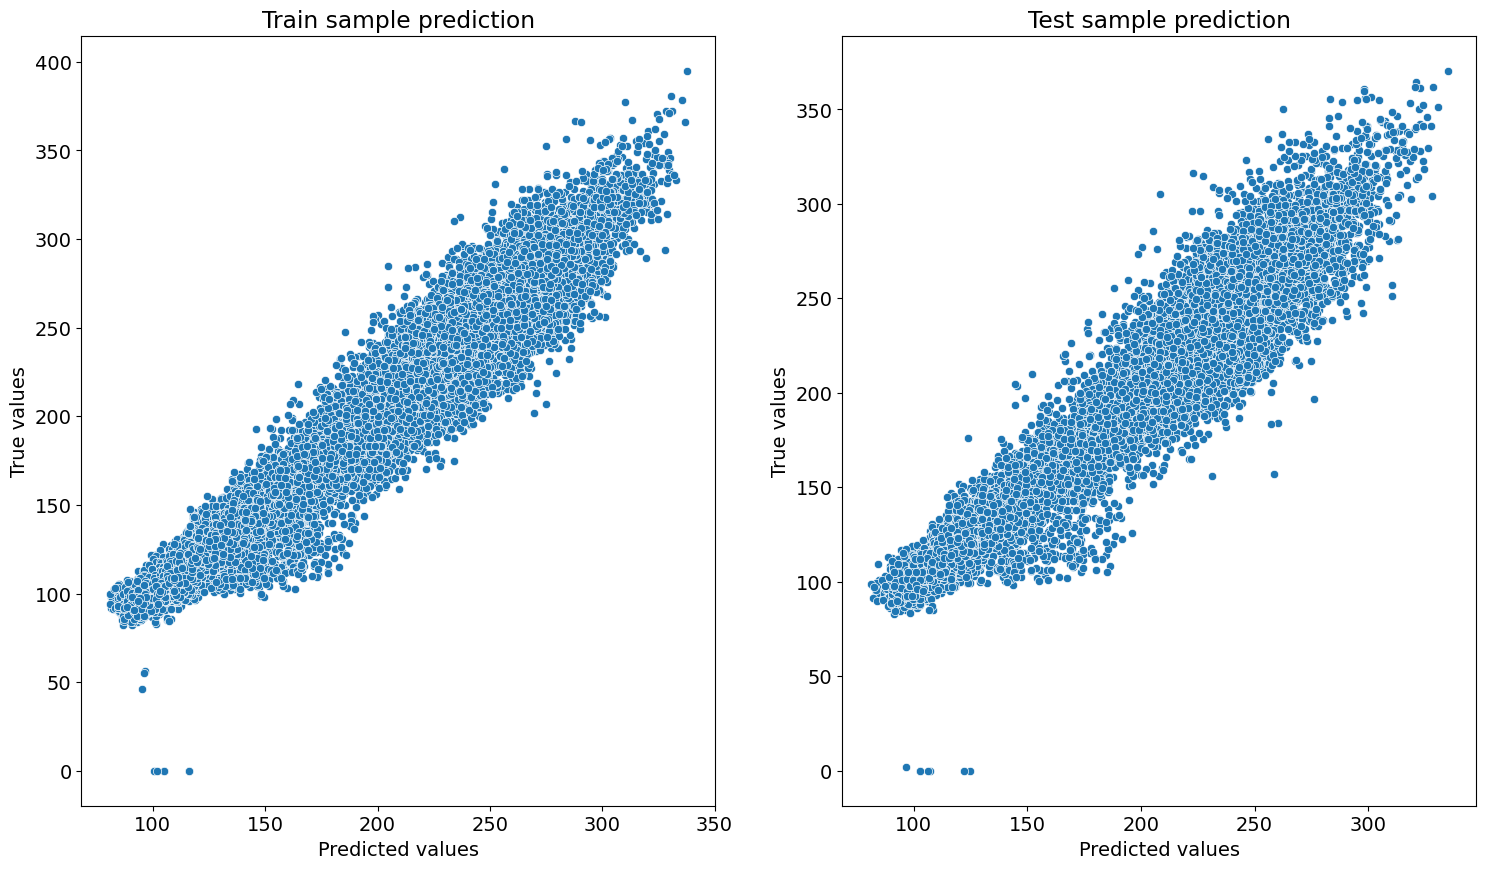

In [63]:
# Визуализируем работу LGBM_model на тренировочных и тестовых данных, выведем метрики

y_train_preds = LGBM_model.predict(X_train)
y_test_preds = LGBM_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### 7.1.2 Настройка и оценка финальной модели (кросс-валидация и выбор гиперпараметров)

In [64]:
"""
LGBM_model = lgb.LGBMRegressor(
    n_estimators=280,
    max_depth= 16,
    learning_rate= 0.1,
    num_leaves= 100,
    min_child_samples= 1,
    min_child_weight= 450,
    random_state= 42)
"""

'\nLGBM_model = lgb.LGBMRegressor(\n    n_estimators=280,\n    max_depth= 16,\n    learning_rate= 0.1,\n    num_leaves= 100,\n    min_child_samples= 1,\n    min_child_weight= 450,\n    random_state= 42)\n'

In [67]:
"""
%%time
# Произведём подбор гиперпараметров для LGBM_model

params = {
        'learning_rate':[0.08, 0.15, 0.3],
        'max_depth':[14, 16, 18],
        'min_child_samples': [1, 2],
        'min_child_weight': [5, 10, 15],
        'n_estimators':[1000, 1500, 2000],
        'num_leaves': [150, 200, 250],
        }
        
gs_LGBM_model = GridSearchCV(LGBM_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=42, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs_LGBM_model.fit(X_train, y_train)
"""

"\n%%time\n# Произведём подбор гиперпараметров для LGBM_model\n\nparams = {\n        'learning_rate':[0.08, 0.15, 0.3],\n        'max_depth':[14, 16, 18],\n        'min_child_samples': [1, 2],\n        'min_child_weight': [5, 10, 15],\n        'n_estimators':[1000, 1500, 2000],\n        'num_leaves': [150, 200, 250],\n        }\n        \ngs_LGBM_model = GridSearchCV(LGBM_model, params, \n                  scoring='r2', # метрика \n                  cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации\n                           random_state=42, \n                           shuffle=True),\n                  n_jobs=-1\n                  )\ngs_LGBM_model.fit(X_train, y_train)\n"

In [69]:
# Посмотрим лучшие параметры LGBM_model
"""
gs_LGBM_model.best_params_
"""

'\ngs_LGBM_model.best_params_\n'

In [70]:
%%time

# Обучим модель LGBM_model

# Light Gradient Boosting Machine Regressor (лёгкий градиентный бустинг деревьев решений - регрессор)

LGBM_model = lgb.LGBMRegressor(
    learning_rate= 0.08,  # hold
    max_depth= 40,        # увеличение почти не влияет
    min_child_samples= 1, # hold
    
    min_child_weight= 5, # hold
    n_estimators= 10000,
    num_leaves= 200, # hold
    
    random_state= 42)

LGBM_model.fit(X_train, y_train)

Wall time: 6min 48s


LGBMRegressor(learning_rate=0.08, max_depth=40, min_child_samples=1,
              min_child_weight=5, n_estimators=10000, num_leaves=200,
              random_state=42)

Train R2:	1.0
Test R2:	0.973
Train RMSE:	0.012
Test RMSE:	9.125
Train MSE:	0.0
Test MSE:	83.266


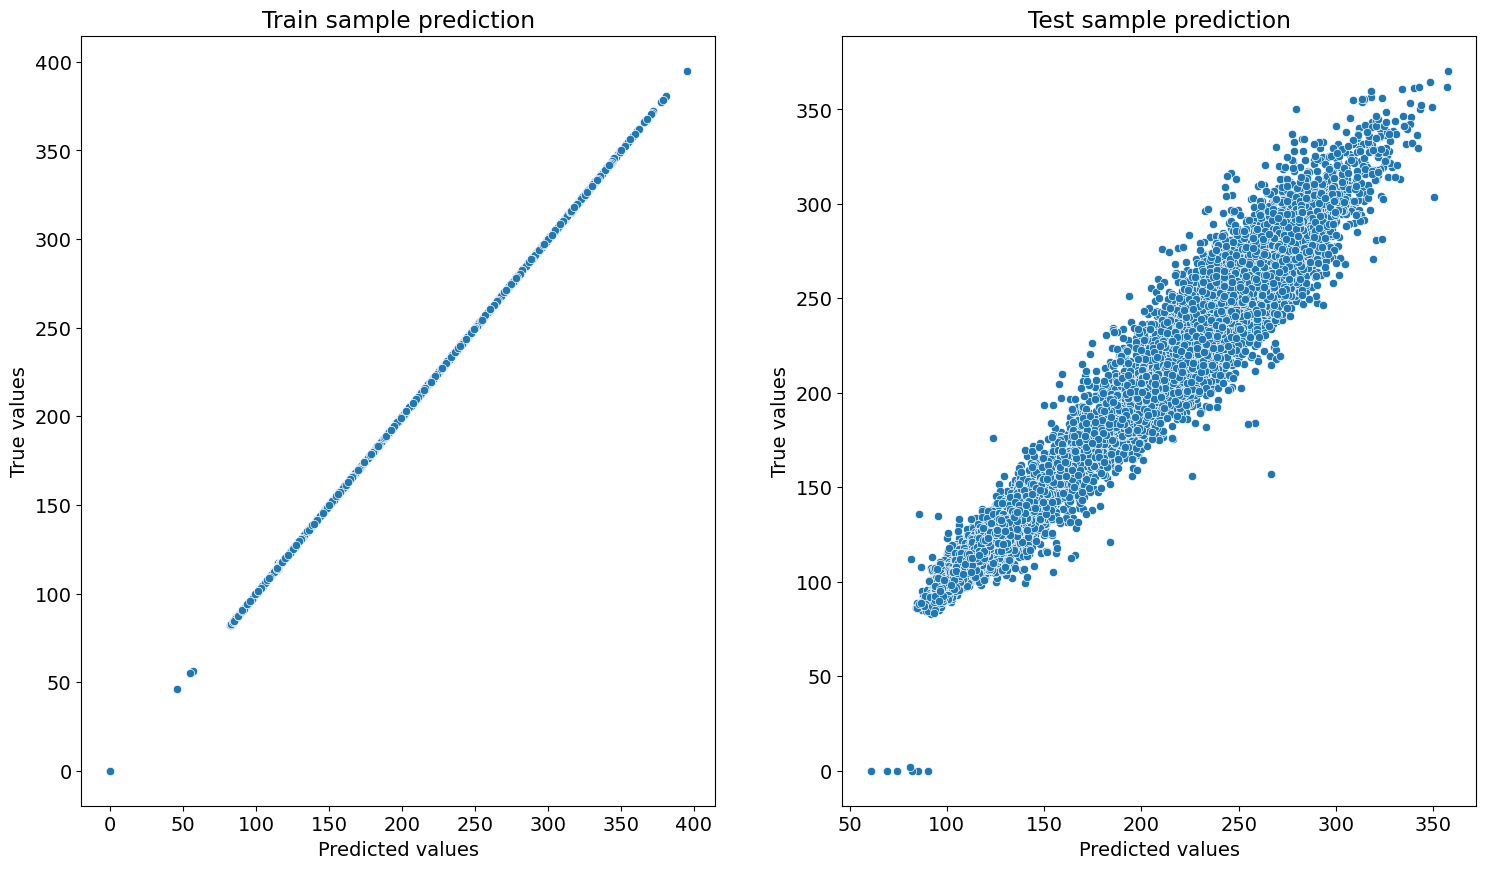

In [71]:
# Визуализируем работу LGBM_model на тренировочных и тестовых данных, выведем метрики

y_train_preds = LGBM_model.predict(X_train)
y_test_preds = LGBM_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Важность признаков

In [72]:
# Посмотрим список признаков по важности влияния на качество модели LGBM_model

feature_importances = pd.DataFrame(zip(X_train.columns, LGBM_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False).head(30)

,feature_name,importance
9,mean_15m_interval_load,98438
29,mean_15m_interval_T2m,65710
51,T2m_multiply_WS10m_minus_H_sun_exponentiation_2,64668
48,Gb(i)_minus_WS10m_divide_T2m_minus_T2m_2,62165
4,WS10m,58141
35,Gd(i)_divide_H_sun,53049
7,mean_day_load,50578
44,T2m_minus_WS10m_exponentiation_2,49474
17,mean_day_Gd(i),48771
3,T2m,47389


In [73]:
# Посмотрим тестовый датафрейм

test_df3.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,mean_year_load,mean_month_load,mean_day_load,mean_weekday_load,mean_15m_interval_load,...,15m_interval_87,15m_interval_88,15m_interval_89,15m_interval_9,15m_interval_90,15m_interval_91,15m_interval_92,15m_interval_93,15m_interval_94,15m_interval_95
0,0.0,0.0,0.0,1.76,1.52,154.214197,158.02239,148.816732,166.373501,120.046537,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,1.57,1.52,154.214197,158.02239,148.816732,166.373501,119.674784,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,1.38,1.52,154.214197,158.02239,148.816732,166.373501,119.096861,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,1.19,1.52,154.214197,158.02239,148.816732,166.373501,119.370671,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,1.00,1.52,154.214197,158.02239,148.816732,166.373501,119.314394,...,0,0,0,0,0,0,0,0,0,0


In [74]:
# Предскажем первую составляющую целевой переменнй - потребляемую нагрузку 'load' по данным тестовой выборки

predictions_load = LGBM_model.predict(test_df3)
predictions_load

array([128.02462227, 128.65151839, 127.14806549, ..., 108.22146179,
       107.01640578, 108.70889366])

In [75]:
# Добавим в тестовый датафрейм предсказанную потребляемую нагрузку

test_df4 = test_df3.copy()
test_df4['load'] = predictions_load
test_df4.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,mean_year_load,mean_month_load,mean_day_load,mean_weekday_load,mean_15m_interval_load,...,15m_interval_88,15m_interval_89,15m_interval_9,15m_interval_90,15m_interval_91,15m_interval_92,15m_interval_93,15m_interval_94,15m_interval_95,load
0,0.0,0.0,0.0,1.76,1.52,154.214197,158.02239,148.816732,166.373501,120.046537,...,0,0,0,0,0,0,0,0,0,128.024622
1,0.0,0.0,0.0,1.57,1.52,154.214197,158.02239,148.816732,166.373501,119.674784,...,0,0,0,0,0,0,0,0,0,128.651518
2,0.0,0.0,0.0,1.38,1.52,154.214197,158.02239,148.816732,166.373501,119.096861,...,0,0,0,0,0,0,0,0,0,127.148065
3,0.0,0.0,0.0,1.19,1.52,154.214197,158.02239,148.816732,166.373501,119.370671,...,0,0,0,0,0,0,0,0,0,128.867160
4,0.0,0.0,0.0,1.00,1.52,154.214197,158.02239,148.816732,166.373501,119.314394,...,0,0,0,0,0,0,0,0,0,128.079279


In [76]:
# Добавим в тренировочный датафрейм колонку с потребляемой электроэнергией - load

train_df4 = train_df3.copy()
train_df4['load'] = train_df_original['load']
train_df4.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,mean_year_load,mean_month_load,mean_day_load,mean_weekday_load,mean_15m_interval_load,...,15m_interval_88,15m_interval_89,15m_interval_9,15m_interval_90,15m_interval_91,15m_interval_92,15m_interval_93,15m_interval_94,15m_interval_95,load
0,0.0,0.0,0.0,9.11,5.38,154.214197,171.168561,141.631944,166.373501,120.046537,...,0,0,0,0,0,0,0,0,0,113.5
1,0.0,0.0,0.0,8.89,5.43,154.214197,171.168561,141.631944,166.373501,119.674784,...,0,0,0,0,0,0,0,0,0,119.0
2,0.0,0.0,0.0,8.66,5.48,154.214197,171.168561,141.631944,166.373501,119.096861,...,0,0,0,0,0,0,0,0,0,117.5
3,0.0,0.0,0.0,8.44,5.54,154.214197,171.168561,141.631944,166.373501,119.370671,...,0,0,0,0,0,0,0,0,0,114.5
4,0.0,0.0,0.0,8.22,5.59,154.214197,171.168561,141.631944,166.373501,119.314394,...,0,0,0,0,0,0,0,0,0,123.0


In [77]:
# Добавим в тренировочный датафрейм колонку с вырабатываемой электроэнергией 'P'

train_df4['P'] = train_df_original['P']
train_df4.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,mean_year_load,mean_month_load,mean_day_load,mean_weekday_load,mean_15m_interval_load,...,15m_interval_89,15m_interval_9,15m_interval_90,15m_interval_91,15m_interval_92,15m_interval_93,15m_interval_94,15m_interval_95,load,P
0,0.0,0.0,0.0,9.11,5.38,154.214197,171.168561,141.631944,166.373501,120.046537,...,0,0,0,0,0,0,0,0,113.5,0.0
1,0.0,0.0,0.0,8.89,5.43,154.214197,171.168561,141.631944,166.373501,119.674784,...,0,0,0,0,0,0,0,0,119.0,0.0
2,0.0,0.0,0.0,8.66,5.48,154.214197,171.168561,141.631944,166.373501,119.096861,...,0,0,0,0,0,0,0,0,117.5,0.0
3,0.0,0.0,0.0,8.44,5.54,154.214197,171.168561,141.631944,166.373501,119.370671,...,0,0,0,0,0,0,0,0,114.5,0.0
4,0.0,0.0,0.0,8.22,5.59,154.214197,171.168561,141.631944,166.373501,119.314394,...,0,0,0,0,0,0,0,0,123.0,0.0


---

### 6.2 Разбиение на train и test для целевой переменной суммарной мощности 'P'

In [78]:
# Разделим тренировочный датасет на входные признаки и целевой признак

target_name = 'P'

X = train_df4.drop(columns=target_name)
y = train_df4[target_name]

In [79]:
# Тренировочный датасет разобъём на тренировочные и валидационные данные

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

X_train.shape, X_test.shape, test_df4.shape

((59437, 205), (29275, 205), (7392, 205))

In [80]:
# Проверим наличие пропусков в выборках

X_train.isna().sum().sum(), X_test.isna().sum().sum(), test_df4.isna().sum().sum()

(88012, 43204, 10874)

---

### 7.2.1 Построение модели для целевой переменной суммарной мощности 'P'

In [81]:
%%time

# Предварительн обучим модель LGBM_model

# Light Gradient Boosting Machine Regressor (лёгкий градиентный бустинг деревьев решений - регрессор)

LGBM_model = lgb.LGBMRegressor(
    n_estimators=280,
    max_depth= 16,
    learning_rate= 0.1,
    num_leaves= 100,
    min_child_samples= 1,
    min_child_weight= 450,
    random_state= 42)

LGBM_model.fit(X_train, y_train)

Wall time: 8.7 s


LGBMRegressor(max_depth=16, min_child_samples=1, min_child_weight=450,
              n_estimators=280, num_leaves=100, random_state=42)

Train R2:	0.966
Test R2:	0.951
Train RMSE:	28.757
Test RMSE:	34.813
Train MSE:	826.965
Test MSE:	1211.916


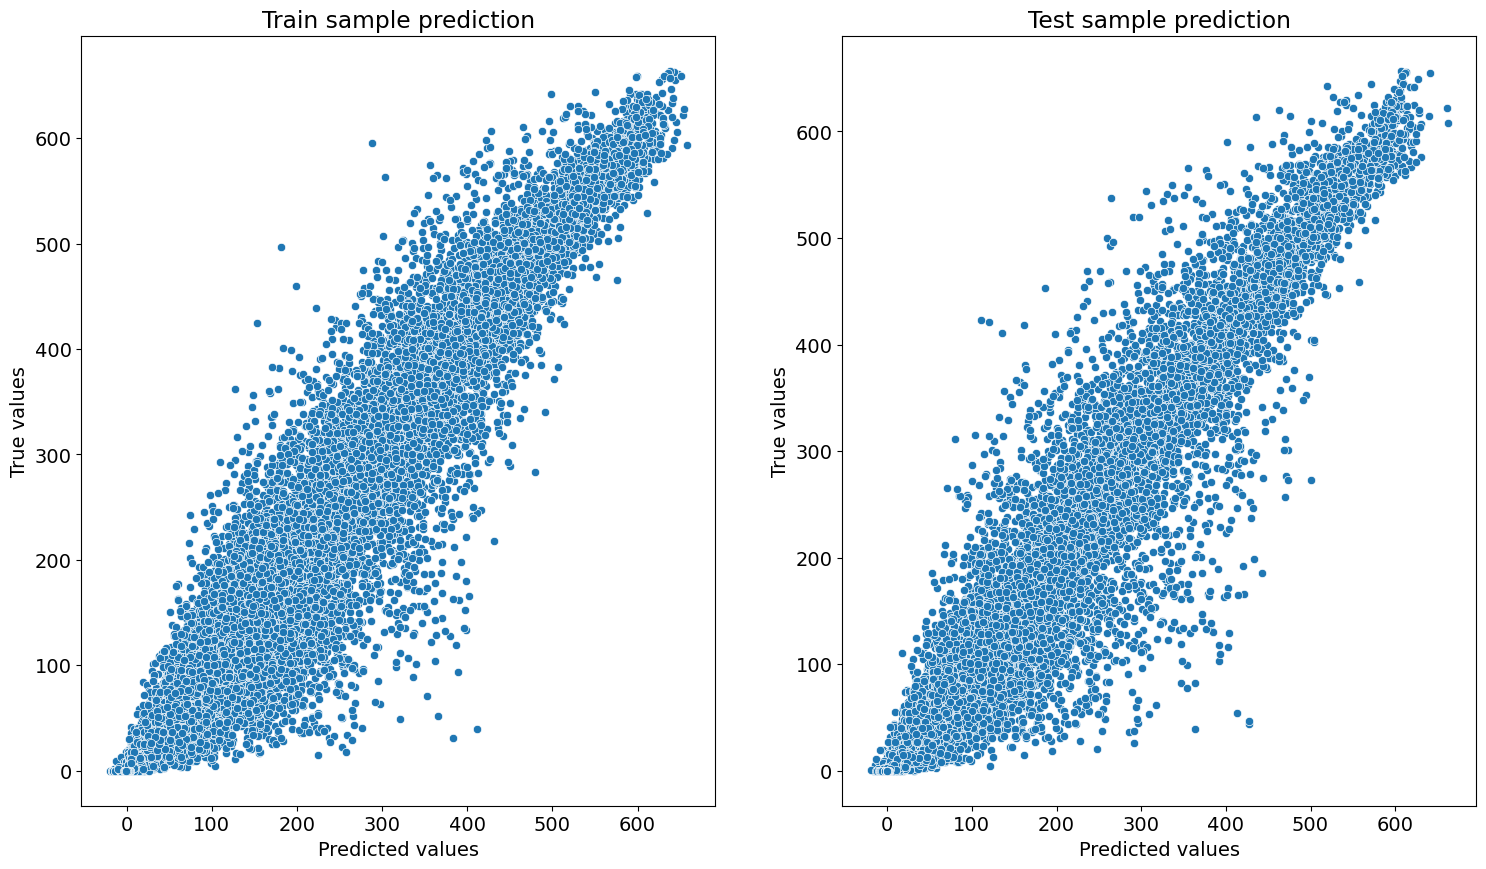

In [82]:
# Визуализируем работу LGBM_model на тренировочных и валидационных данных, выведем метрики

y_train_preds = LGBM_model.predict(X_train)
y_test_preds = LGBM_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### 7.2.2 Настройка и оценка финальной модели (кросс-валидация и выбор гиперпараметров)

In [83]:
"""
LGBM_model = lgb.LGBMRegressor(
    n_estimators=280,
    max_depth= 16,
    learning_rate= 0.1,
    num_leaves= 100,
    min_child_samples= 1,
    min_child_weight= 450,
    random_state= 42)
"""

'\nLGBM_model = lgb.LGBMRegressor(\n    n_estimators=280,\n    max_depth= 16,\n    learning_rate= 0.1,\n    num_leaves= 100,\n    min_child_samples= 1,\n    min_child_weight= 450,\n    random_state= 42)\n'

In [86]:
"""
%%time
# Произведём подбор гиперпараметров для LGBM_model

params = {
        'learning_rate':[0.1, 0.3, 0.5],
        'max_depth':[14, 16, 18],
        'min_child_samples': [1],
        'min_child_weight': [10, 20, 30],
        'n_estimators':[1000, 1500, 2000],
        'num_leaves': [150, 200, 250]
            }
        
gs_LGBM_model = GridSearchCV(LGBM_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=42, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs_LGBM_model.fit(X_train, y_train)
"""

"\n%%time\n# Произведём подбор гиперпараметров для LGBM_model\n\nparams = {\n        'learning_rate':[0.1, 0.3, 0.5],\n        'max_depth':[14, 16, 18],\n        'min_child_samples': [1],\n        'min_child_weight': [10, 20, 30],\n        'n_estimators':[1000, 1500, 2000],\n        'num_leaves': [150, 200, 250]\n            }\n        \ngs_LGBM_model = GridSearchCV(LGBM_model, params, \n                  scoring='r2', # метрика \n                  cv=KFold(n_splits=3,   # k (кол-во разбиений/итераций) в кросс-валидации\n                           random_state=42, \n                           shuffle=True),\n                  n_jobs=-1\n                  )\ngs_LGBM_model.fit(X_train, y_train)\n"

In [87]:
# Посмотрим лучшие параметры LGBM_model
"""
gs_LGBM_model.best_params_
"""

'\ngs_LGBM_model.best_params_\n'

In [88]:
%%time

# Обучим модель LGBM_model

# Light Gradient Boosting Machine Regressor (лёгкий градиентный бустинг деревьев решений - регрессор)

LGBM_model = lgb.LGBMRegressor(
    learning_rate= 0.08,  # hold
    max_depth= 40,        # увеличение почти не влияет
    min_child_samples= 1, # hold
    
    min_child_weight= 5, # hold
    n_estimators= 10000,
    num_leaves= 200, # hold
    
    random_state= 42)

LGBM_model.fit(X_train, y_train)

Wall time: 7min 48s


LGBMRegressor(learning_rate=0.08, max_depth=40, min_child_samples=1,
              min_child_weight=5, n_estimators=10000, num_leaves=200,
              random_state=42)

Train R2:	1.0
Test R2:	0.982
Train RMSE:	0.0
Test RMSE:	21.124
Train MSE:	0.0
Test MSE:	446.205


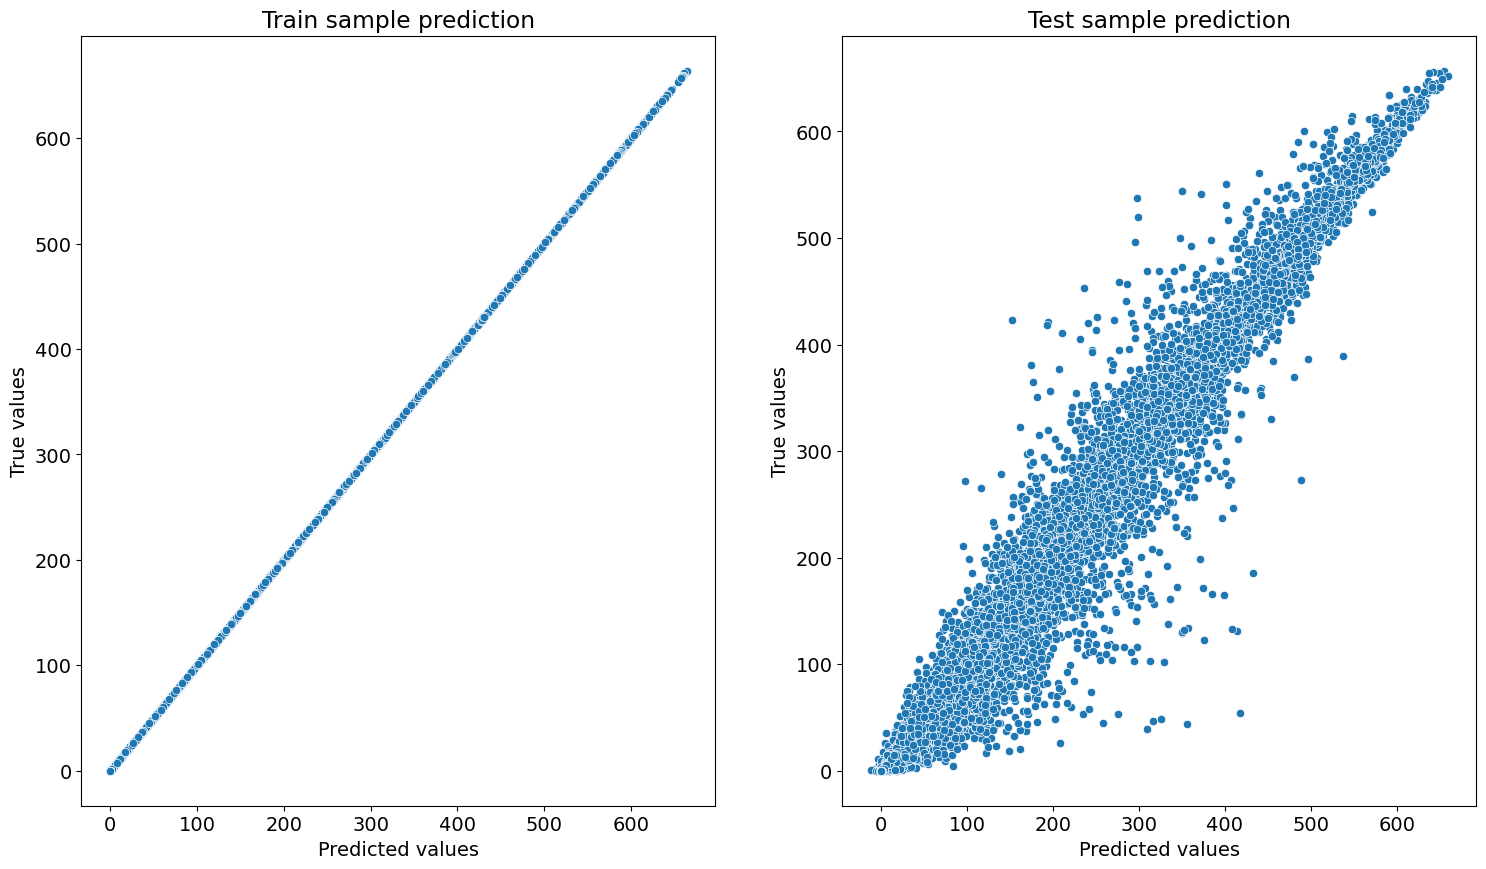

In [89]:
# Визуализируем работу LGBM_model на тренировочных и валидационных данных, выведем метрики

y_train_preds = LGBM_model.predict(X_train)
y_test_preds = LGBM_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

#### Важность признаков

In [90]:
# Посмотрим список признаков по важности влияния на качество модели LGBM_model

feature_importances = pd.DataFrame(zip(X_train.columns, LGBM_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False).head(30)

,feature_name,importance
204,load,132445
35,Gd(i)_divide_H_sun,71940
9,mean_15m_interval_load,71751
51,T2m_multiply_WS10m_minus_H_sun_exponentiation_2,66478
48,Gb(i)_minus_WS10m_divide_T2m_minus_T2m_2,57788
29,mean_15m_interval_T2m,54585
4,WS10m,49497
1,Gd(i),49064
39,Gb(i)_minus_T2m_multiply_WS10m,46163
36,H_sun_minus_T2m,45279


---

### 8. Прогнозирование на тестовом датасете

In [91]:
# Посмотрим тестовый датафрейм

test_df4.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,mean_year_load,mean_month_load,mean_day_load,mean_weekday_load,mean_15m_interval_load,...,15m_interval_88,15m_interval_89,15m_interval_9,15m_interval_90,15m_interval_91,15m_interval_92,15m_interval_93,15m_interval_94,15m_interval_95,load
0,0.0,0.0,0.0,1.76,1.52,154.214197,158.02239,148.816732,166.373501,120.046537,...,0,0,0,0,0,0,0,0,0,128.024622
1,0.0,0.0,0.0,1.57,1.52,154.214197,158.02239,148.816732,166.373501,119.674784,...,0,0,0,0,0,0,0,0,0,128.651518
2,0.0,0.0,0.0,1.38,1.52,154.214197,158.02239,148.816732,166.373501,119.096861,...,0,0,0,0,0,0,0,0,0,127.148065
3,0.0,0.0,0.0,1.19,1.52,154.214197,158.02239,148.816732,166.373501,119.370671,...,0,0,0,0,0,0,0,0,0,128.867160
4,0.0,0.0,0.0,1.00,1.52,154.214197,158.02239,148.816732,166.373501,119.314394,...,0,0,0,0,0,0,0,0,0,128.079279


In [92]:
# Предскажем целевую переменную по данным тестовой выборки

predictions_P = LGBM_model.predict(test_df4)
predictions_P

array([-0.74166246, -0.66055475, -0.50357615, ..., -0.29698637,
       -0.28154609, -0.30739111])

In [93]:
# Добавим в тестовый датафрейм колонку с предсказанной вырабатываемой энергией 'P'

test_df4['P'] = predictions_P
test_df4.head()

,Gb(i),Gd(i),H_sun,T2m,WS10m,mean_year_load,mean_month_load,mean_day_load,mean_weekday_load,mean_15m_interval_load,...,15m_interval_89,15m_interval_9,15m_interval_90,15m_interval_91,15m_interval_92,15m_interval_93,15m_interval_94,15m_interval_95,load,P
0,0.0,0.0,0.0,1.76,1.52,154.214197,158.02239,148.816732,166.373501,120.046537,...,0,0,0,0,0,0,0,0,128.024622,-0.741662
1,0.0,0.0,0.0,1.57,1.52,154.214197,158.02239,148.816732,166.373501,119.674784,...,0,0,0,0,0,0,0,0,128.651518,-0.660555
2,0.0,0.0,0.0,1.38,1.52,154.214197,158.02239,148.816732,166.373501,119.096861,...,0,0,0,0,0,0,0,0,127.148065,-0.503576
3,0.0,0.0,0.0,1.19,1.52,154.214197,158.02239,148.816732,166.373501,119.370671,...,0,0,0,0,0,0,0,0,128.867160,-0.019438
4,0.0,0.0,0.0,1.00,1.52,154.214197,158.02239,148.816732,166.373501,119.314394,...,0,0,0,0,0,0,0,0,128.079279,-1.188402


In [94]:
train_df_original.loc[train_df_original['P'] != 0]

,time,P,Gb(i),Gd(i),H_sun,T2m,WS10m,load,residual_load,dataset_id
29,2018-01-01 07:15:00,4.26,5.27,6.73,1.08,5.40,5.65,132.0,127.74,1
30,2018-01-01 07:30:00,8.51,10.54,13.46,2.15,5.30,5.52,133.0,124.49,1
31,2018-01-01 07:45:00,12.77,15.82,20.19,3.23,5.21,5.38,133.0,120.23,1
32,2018-01-01 08:00:00,17.02,21.09,26.92,4.31,5.11,5.24,131.5,114.48,1
33,2018-01-01 08:15:00,30.69,16.68,35.17,5.74,5.14,5.20,124.0,93.31,1
...,...,...,...,...,...,...,...,...,...,...
88679,2020-10-10 15:45:00,50.76,34.50,39.36,5.90,10.52,3.24,90.0,39.24,11
88680,2020-10-10 16:00:00,15.79,19.15,20.35,3.72,10.35,2.97,86.0,70.21,11
88681,2020-10-10 16:15:00,11.85,14.36,15.26,2.79,10.17,2.92,89.5,77.65,11
88682,2020-10-10 16:30:00,7.90,9.57,10.18,1.86,9.99,2.86,87.0,79.10,11


In [95]:
predictions = test_df4['load'] - test_df4['P']
predictions

0       128.766285
1       129.312073
2       127.651642
3       128.886598
4       129.267681
           ...    
7387    108.889716
7388    108.645033
7389    108.518448
7390    107.297952
7391    109.016285
Length: 7392, dtype: float64

In [96]:
submission_df = pd.DataFrame(columns = ["time", "residual_load"])
submission_df.head()

,time,residual_load


In [97]:
submission_df["time"] = test_df["time"].copy()
submission_df["residual_load"] = predictions.copy()
submission_df.head()

,time,residual_load
0,2018-03-26 00:00:00,128.766285
1,2018-03-26 00:15:00,129.312073
2,2018-03-26 00:30:00,127.651642
3,2018-03-26 00:45:00,128.886598
4,2018-03-26 01:00:00,129.267681


In [98]:
# Запишем датафрейм submit в csv-файл

submission_df.to_csv('submission9_1.csv', index = False)

---